# Price Model Data Exploration

This notebook is a first attempt to model allowed amounts

## Notebook Setup and Local Functions

### Install packages

In [1]:
#install h20 for modeling exploration, need to set this up on hub
!pip install h2o

     |████████████████████████████████| 164.8 MB 160 kB/s eta 0:00:011  |▊                               | 3.5 MB 6.3 MB/s eta 0:00:26
  Created wheel for h2o: filename=h2o-3.32.1.3-py2.py3-none-any.whl size=164854343 sha256=c78991ced012c45b256afd1334e1be7af89d495c038cdbd8253e82569dcbf965
  Stored in directory: /home/jovyan/.cache/pip/wheels/57/9a/fe/6497c36421fea78cd1ff30340348adad41801fa97de2dc42d5
Successfully built h2o


### Import libraries

In [2]:
#basic math/stats/graphs libraries
import numpy as np
from numpy import sqrt, exp, log, mean
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from math import ceil, floor
from ipywidgets import Layout, Button, Box, FloatText, Textarea,Dropdown, Label, IntSlider, Checkbox, interact, interactive
sns.set_style("whitegrid")

In [3]:
#basic model/pandas libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from datetime import datetime
import h2o
from h2o.automl import H2OAutoML

In [4]:
#install snowflake connector
import sys 
#pull in snowflake login snippets
sys.path.append('/efs/kamalesh')
import jupyter_toolz as jt

Snowflake user name: ········
Password: ········


### Define functions

In [7]:
#generic function to pull in table from snowflake

def pull_snfdb(db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"',
               select_statement=None, limit=None, where=None, 
               diag=False, sample_n=None):
    
    if select_statement is not None:
        sql=select_statement 
    
    else:
        sql = f"""select * 
         from {db}
        """ 
    if sample_n is not None:
        sql+=f""" sample row ({sample_n} rows) 
        """ 
    if where is not None:
        sql+=f""" where {where} 
        """
    if limit is not None:
        sql+=f""" limit {limit}
        """
    if not diag:
        temp_df=jt.read_sql(sql)
        return temp_df
    else:
        print(sql)
        return sql

#function for summarizing data within snowflake
def pull_snfdb_dist_summ(x='x', db='"SANDBOX_KRAO"."EDA"."PROCEDURE_COST_TABLE"'
                         , name_list=['count','stddev','min', '1percentile', '5percentile',
                                      '10percentile','25percentile',
                                     'average','median','75percentile','90percentile',
                                      '95percentile','99percentile','max']):
    sql = f"""select 
        count(*) as count
        ,stddev({x}) as stddev
        ,min({x}::float) as min
        ,approx_percentile({x}::float,.01) as percentile_1
        ,approx_percentile({x}::float,.05) as percentile_5
        ,approx_percentile({x}::float,.1) as percentile_10
        ,approx_percentile({x}::float,.25) as percentile_25
        ,avg({x}::float) as average
        ,median({x}::float) as median
        ,approx_percentile({x}::float,.75) as percentile_75
        ,approx_percentile({x}::float,.9) as percentile_90
        ,approx_percentile({x}::float,.95) as percentile_95
        ,approx_percentile({x}::float,.99) as percentile_99
         ,max({x}::float) as max
         from {db}
        """ 
    temp_df=jt.read_sql(sql)
    temp_df.columns=[x+'_'+y for y in name_list]
    return temp_df

In [8]:
def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    return current_time

### Define Databases

In [9]:
#encounters database
enc_db='"MAP_ENCOUNTERS"."MX_ENCOUNTERS_20210104"."ENCOUNTERSMX_LS_GA"'

#allowed amounts database
aa_db='"MAP_ENCOUNTERS"."MX_ENCOUNTERS_20210104"."ALLOWEDAMOUNTS_GA"'

#enhanced allowed amounts database (Jan, Feb 2020)
aa_enh_db='"SANDBOX_KRAO"."EDA"."ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (.01% sample)
aa_enh_db_001pct='"SANDBOX_KRAO"."EDA"."RANDOM_001PCT_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (.1% sample)
aa_enh_db_01pct='"SANDBOX_KRAO"."EDA"."RANDOM_01PCT_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#enhanced allowed amounts database (1M random sample)
aa_enh_db_1M='"SANDBOX_KRAO"."EDA"."RANDOM_1M_ENHANCED_ENCOUNTERS_W_ALLOWED_AMOUNTS"'

#sum costs per patient and soc
aa_sum_cost_pp_soc='"SANDBOX_KRAO"."EDA"."SUM_COST_PER_PATIENT_SOC"'

#sum costs per patient and soc (1 M sample)
aa_sum_cost_pp_soc_1M='"SANDBOX_KRAO"."EDA"."SUM_COST_PER_PATIENT_SOC_1M_SAMPLE"'



In [10]:
#create pandas data frames for 1% samples
aa_enh_db_01pct_df=pull_snfdb(db=aa_enh_db_01pct)
aa_enh_db_01pct_df=aa_enh_db_01pct_df[aa_enh_db_01pct_df["ALLOWED_AMOUNT"].notna()]
aa_enh_db_01pct_df["LINE_CHARGE"]=aa_enh_db_01pct_df["LINE_CHARGE"].astype(float)

#create pandas data frames for .1% samples
aa_enh_db_001pct_df=pull_snfdb(db=aa_enh_db_001pct)
aa_enh_db_001pct_df=aa_enh_db_001pct_df[aa_enh_db_001pct_df["ALLOWED_AMOUNT"].notna()]
aa_enh_db_001pct_df["LINE_CHARGE"]=aa_enh_db_001pct_df["LINE_CHARGE"].astype(float)

#create pandas data frames for 1M samples
aa_enh_db_1M_df=pull_snfdb(db=aa_enh_db_1M)
aa_enh_db_1M_df=aa_enh_db_1M_df[aa_enh_db_1M_df["ALLOWED_AMOUNT"].notna()]
aa_enh_db_1M_df["LINE_CHARGE"]=aa_enh_db_1M_df["LINE_CHARGE"].astype(float)

In [12]:
aa_enh_db_1M_df.head().T

,405,406,407,408,409
CLAIM_DATE,2020-02-13,2020-02-06,2020-02-06,2020-02-18,2020-01-09
ENCOUNTER_KEY,2fde2acf33a4ceb65d132e40800214ac8532a128,f6a148f59c928f570585972701d018f99357d0ba,f6a148f59c928f570585972701d018f99357d0ba,15b5d03445ca033b9d91b603c722903e3d0256be,b8e7b6089c20a8415d862d662b1ba3d9e16a4bf1
VISIT_ID,175b2ecb0a4581de9f773b72c0e76fdcb2f2ea77,389cab18d1cfa8099c2bb49bdaa3b5b62f4a0908,389cab18d1cfa8099c2bb49bdaa3b5b62f4a0908,2dd6b7bbb94470680e571edceb0affca671c60af,c1f3d849a061702d385d2e167169dfe6939868ce
SOURCES_ARRAY,"[\n ""fleming-nightingale""\n]","[\n ""fleming-nightingale""\n]","[\n ""fleming-nightingale""\n]","[\n ""rowley""\n]","[\n ""fleming-peso"",\n ""rowley""\n]"
PATIENT_STATE,NJ,NM,NM,IL,IL
HCP_1_NPI,1144293499,1669511663,1669511663,None,None
HCO_1_NPI,1104859131,1164475232,1164475232,1871006239,1801886809
TOTAL_CLAIM_CHARGE_AMOUNT,956,1074.68,1074.68,NaN,0
PAYER_KH_ID,186,186,186,17,251
PAYER_KH_ID_IMPUTE_FLAG,False,False,False,False,False


### Generate Regression data frames

#### Model Formula

\begin{equation*}
log(y_i-y_m-\overline{p})=\overrightarrow{STATE_i}+\overrightarrow{PAYERID_i}+\overrightarrow{PROCEDURE_i}+\overrightarrow{CHANNEL_i}\end{equation*}

\begin{equation*}
y_m: trimmed mean procedure price
\end{equation*}

\begin{equation*}
\overline{p}: trimmed mean procedure price
\end{equation*}


\begin{equation*}
\overrightarrow{STATE_i}: vector of state dummy variables
\end{equation*}

\begin{equation*}
\overrightarrow{PAYERID_i}: vector of payer IDs
\end{equation*}

\begin{equation*}
\overrightarrow{PROCEDURE_i}: vector of procedure ids
\end{equation*}

\begin{equation*}
\overrightarrow{CHANNEL_i}: vector of channel ids
\end{equation*}

In [11]:
keep_cols=xNames=['PROCEDURE','PATIENT_STATE', 'PAYER_KH_ID', 'PAYER_CHANNEL',
       'CLAIM_TYPE_CODE', 'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE', 'VISIT_SETTING_OF_CARE', 'ALLOWED_AMOUNT']

xNames=['PATIENT_STATE', 'PAYER_KH_ID', 'PAYER_CHANNEL',
       'CLAIM_TYPE_CODE', 'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE']

xNames_1=['PATIENT_STATE', 'PAYER_KH_ID', 'PAYER_CHANNEL',
       'CLAIM_TYPE_CODE', 'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE', 'VISIT_SETTING_OF_CARE']

yName='LOG_ALLOWED_AMOUNT_CENTER'

yName1='LOG_ALLOWED_AMOUNT'

#### Split into "prior/model data": prior is to calculate global and procedure mean

In [13]:
#split into prior, modeling frames
X_prior, X_model= train_test_split(aa_enh_db_1M_df[keep_cols],
                                    test_size=0.33, random_state=0)

In [14]:
#calculate global mean and procedure mean of prior frame and fold into regression frame 

price_proc_summary=X_prior.groupby(by="PROCEDURE").agg({'ALLOWED_AMOUNT':['mean']}).reset_index()
price_proc_summary.columns=['PROCEDURE','PROC_PRICE_MEAN']
price_mean=mean(X_prior['ALLOWED_AMOUNT'])

X_model=X_model.merge(price_proc_summary, on="PROCEDURE",how="left")
X_model['GLOBAL_PRICE_MEAN']=price_mean
X_model.loc[X_model['PROC_PRICE_MEAN'].isna(),'PROC_PRICE_MEAN']=price_mean
X_model["LOG_ALLOWED_AMOUNT_CENTER"]=log(X_model["ALLOWED_AMOUNT"])/log(X_model["PROC_PRICE_MEAN"])
X_model=X_model[~X_model["LOG_ALLOWED_AMOUNT_CENTER"].isna()]


In [15]:
X_model.head().T

,0,1,2,3,4
PROCEDURE,"""Q9967""","""99232""","""96372""","""99213""","""A7030"""
PATIENT_STATE,OK,AL,TX,IL,IN
PAYER_KH_ID,11,186,266,14,186
PAYER_CHANNEL,Commercial,Commercial,Commercial,Commercial,Commercial
CLAIM_TYPE_CODE,I,P,I,P,P
MODIFIER_1,"""JW""",None,None,"""25""","""NU"""
MODIFIER_2,None,None,None,None,"""KX"""
UNITS,None,1,None,1,1
PLACE_OF_SERVICE,"""22""","""21""","""22""","""11""","""12"""
VISIT_SETTING_OF_CARE,Outpatient Visit,Inpatient Visit,Outpatient Visit,Outpatient Visit,Home Visit


Note: Need more elegant way of handling log(1)/log(1) cases when calculating log amounts

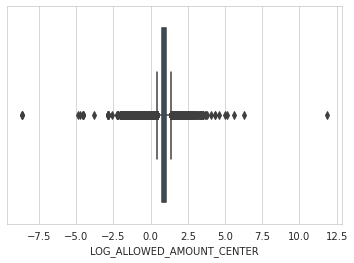

In [52]:
sns.boxplot(x=X_model["LOG_ALLOWED_AMOUNT_CENTER"])

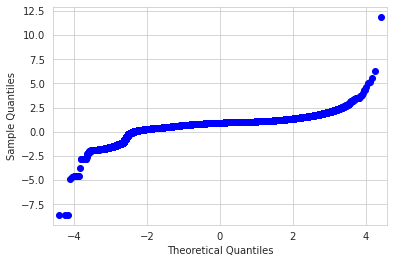

In [58]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

a = np.random.normal(5, 5, 250)
sm.qqplot(X_model["LOG_ALLOWED_AMOUNT_CENTER"])
plt.show()

Note: Not normally distributed

### Run Basic Model

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_model,
                                                    X_model[yName],
                                                    test_size=0.5, random_state=0)

In [12]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_282"; OpenJDK Runtime Environment (build 1.8.0_282-8u282-b08-0ubuntu1~18.04-b08); OpenJDK 64-Bit Server VM (build 25.282-b08, mixed mode)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbilll_ug
  JVM stdout: /tmp/tmpbilll_ug/h2o_jovyan_started_from_python.out
  JVM stderr: /tmp/tmpbilll_ug/h2o_jovyan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_jovyan_52kjgg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10 Gb
H2O_cluster_total_cores:,7
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"accepting new members, healthy"


In [165]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=600, seed=1)
trainH2o=h2o.H2OFrame(pd.concat([y_train,X_train[xNames] ], axis=1))
testH2o=h2o.H2OFrame(pd.concat([y_test,X_test[xNames]], axis=1))
aml.train(x=xNames, y=yName, training_frame=trainH2o,
          validation_frame=testH2o,leaderboard_frame=testH2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
16:17:37.963: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [166]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210417_161737,0.0684406,0.261612,0.0684406,0.155776,nan
StackedEnsemble_BestOfFamily_AutoML_20210417_161737,0.0687205,0.262146,0.0687205,0.156215,nan
XGBoost_grid__1_AutoML_20210417_161737_model_3,0.0694028,0.263444,0.0694028,0.158172,nan
XGBoost_2_AutoML_20210417_161737,0.0696493,0.263912,0.0696493,0.158109,nan
XGBoost_grid__1_AutoML_20210417_161737_model_1,0.069911,0.264407,0.069911,0.158577,nan
XGBoost_grid__1_AutoML_20210417_161737_model_2,0.0700606,0.26469,0.0700606,0.159457,nan
GBM_4_AutoML_20210417_161737,0.0701477,0.264854,0.0701477,0.158279,nan
XGBoost_1_AutoML_20210417_161737,0.0703563,0.265248,0.0703563,0.15968,nan
XGBoost_grid__1_AutoML_20210417_161737_model_4,0.0707986,0.26608,0.0707986,0.158639,nan
GBM_3_AutoML_20210417_161737,0.0708311,0.266141,0.0708311,0.15909,nan


In [167]:
model_ids=aml.leaderboard.as_data_frame()["model_id"].tolist()

In [168]:
model_ids

['StackedEnsemble_AllModels_AutoML_20210417_161737',
 'StackedEnsemble_BestOfFamily_AutoML_20210417_161737',
 'XGBoost_grid__1_AutoML_20210417_161737_model_3',
 'XGBoost_2_AutoML_20210417_161737',
 'XGBoost_grid__1_AutoML_20210417_161737_model_1',
 'XGBoost_grid__1_AutoML_20210417_161737_model_2',
 'GBM_4_AutoML_20210417_161737',
 'XGBoost_1_AutoML_20210417_161737',
 'XGBoost_grid__1_AutoML_20210417_161737_model_4',
 'GBM_3_AutoML_20210417_161737',
 'DRF_1_AutoML_20210417_161737',
 'GBM_5_AutoML_20210417_161737',
 'GBM_grid__1_AutoML_20210417_161737_model_2',
 'GBM_2_AutoML_20210417_161737',
 'GBM_1_AutoML_20210417_161737',
 'GBM_grid__1_AutoML_20210417_161737_model_3',
 'XGBoost_grid__1_AutoML_20210417_161737_model_5',
 'XGBoost_3_AutoML_20210417_161737',
 'GBM_grid__1_AutoML_20210417_161737_model_4',
 'XRT_1_AutoML_20210417_161737',
 'GBM_grid__1_AutoML_20210417_161737_model_1',
 'DeepLearning_grid__1_AutoML_20210417_161737_model_1',
 'DeepLearning_1_AutoML_20210417_161737',
 'DeepLe

StackedEnsemble_AllModels_AutoML_20210417_161737
plot attempt failed
StackedEnsemble_BestOfFamily_AutoML_20210417_161737
plot attempt failed
XGBoost_grid__1_AutoML_20210417_161737_model_3


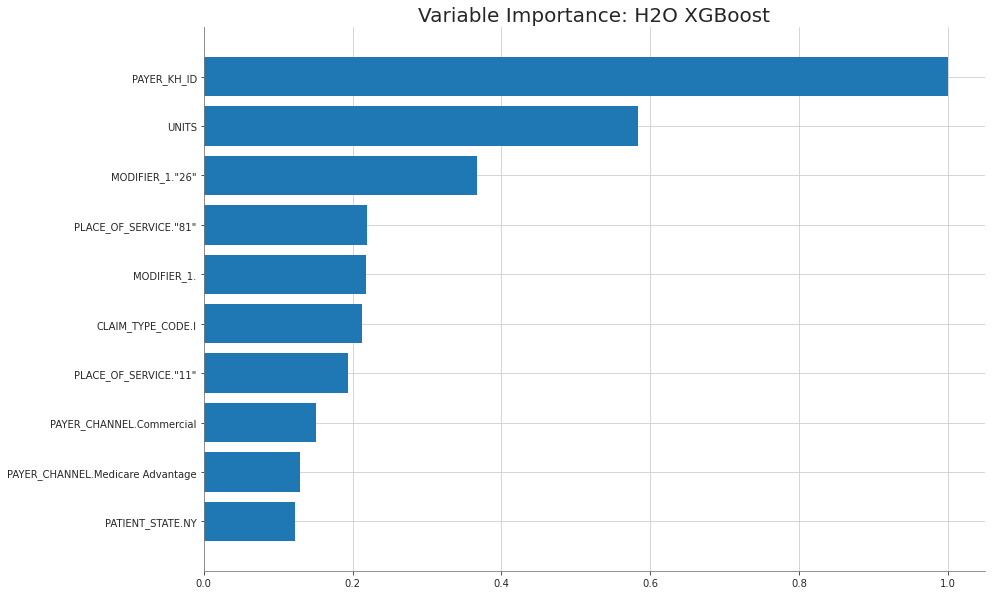

XGBoost_2_AutoML_20210417_161737


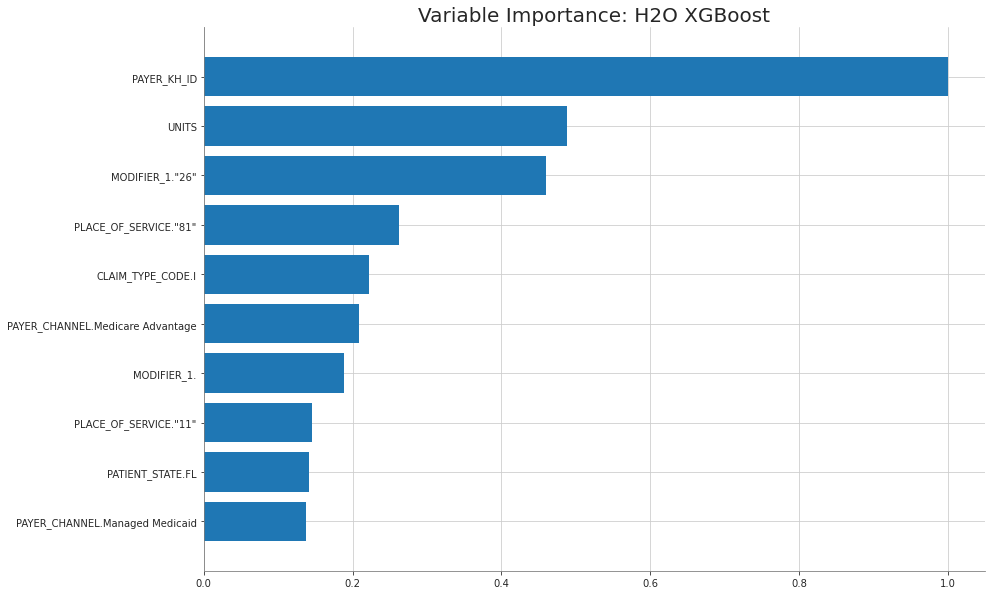

XGBoost_grid__1_AutoML_20210417_161737_model_1


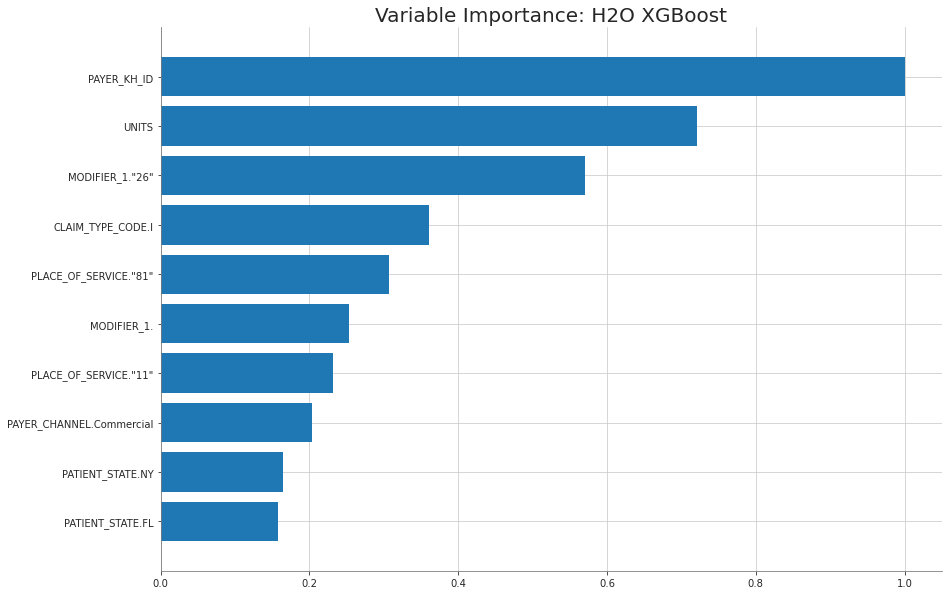

XGBoost_grid__1_AutoML_20210417_161737_model_2


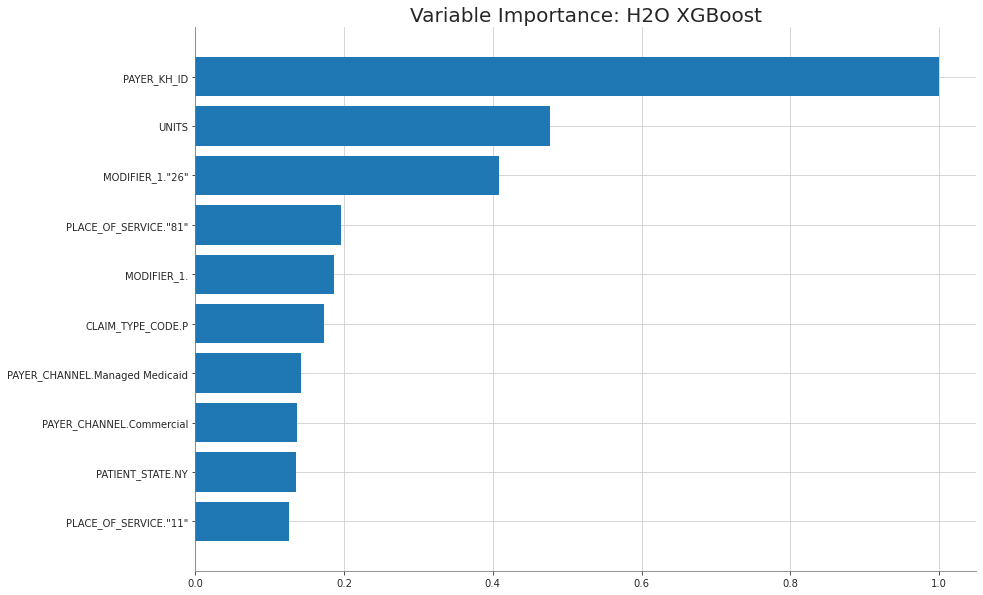

GBM_4_AutoML_20210417_161737


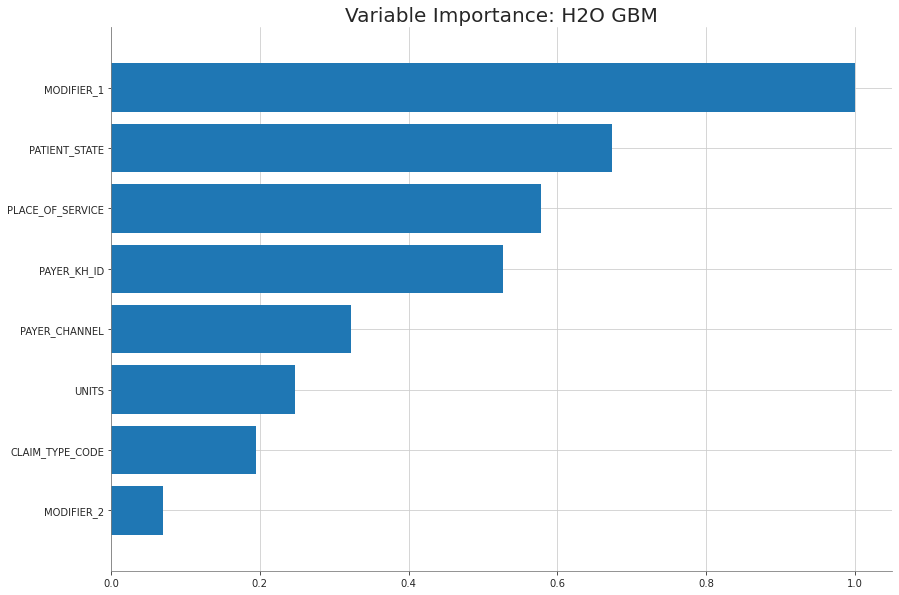

XGBoost_1_AutoML_20210417_161737


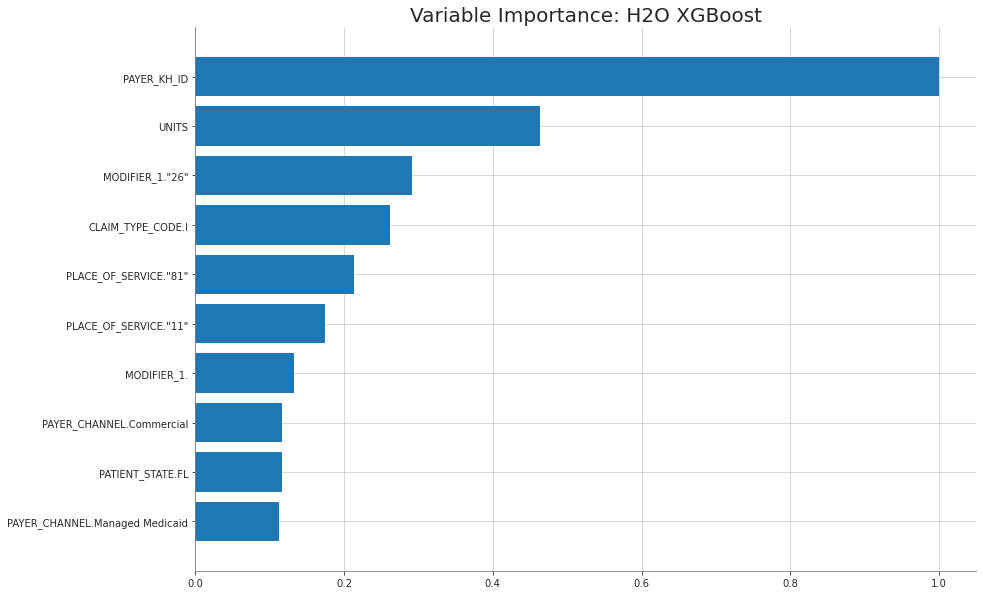

XGBoost_grid__1_AutoML_20210417_161737_model_4


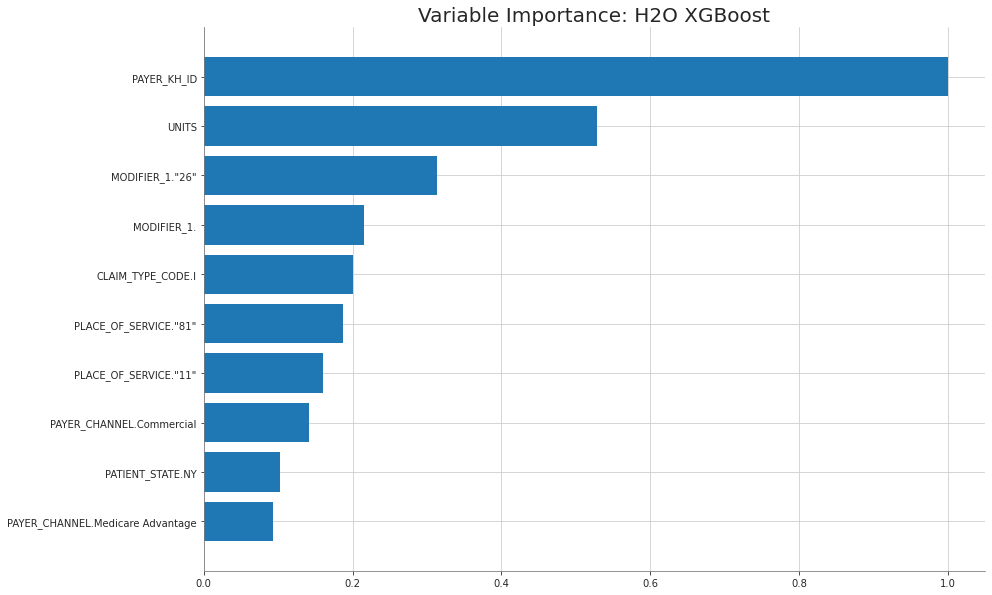

GBM_3_AutoML_20210417_161737


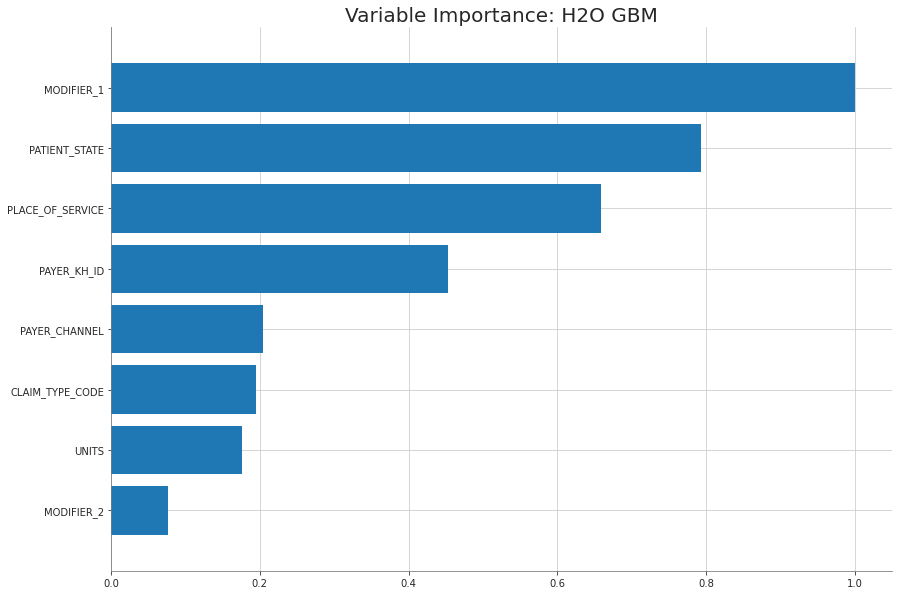

In [169]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.varimp_plot()
    except:
        print ("plot attempt failed")

StackedEnsemble_AllModels_AutoML_20210417_161737
StackedEnsemble_BestOfFamily_AutoML_20210417_161737
XGBoost_grid__1_AutoML_20210417_161737_model_3
XGBoost_2_AutoML_20210417_161737
XGBoost_grid__1_AutoML_20210417_161737_model_1
XGBoost_grid__1_AutoML_20210417_161737_model_2
GBM_4_AutoML_20210417_161737
XGBoost_1_AutoML_20210417_161737
XGBoost_grid__1_AutoML_20210417_161737_model_4
GBM_3_AutoML_20210417_161737


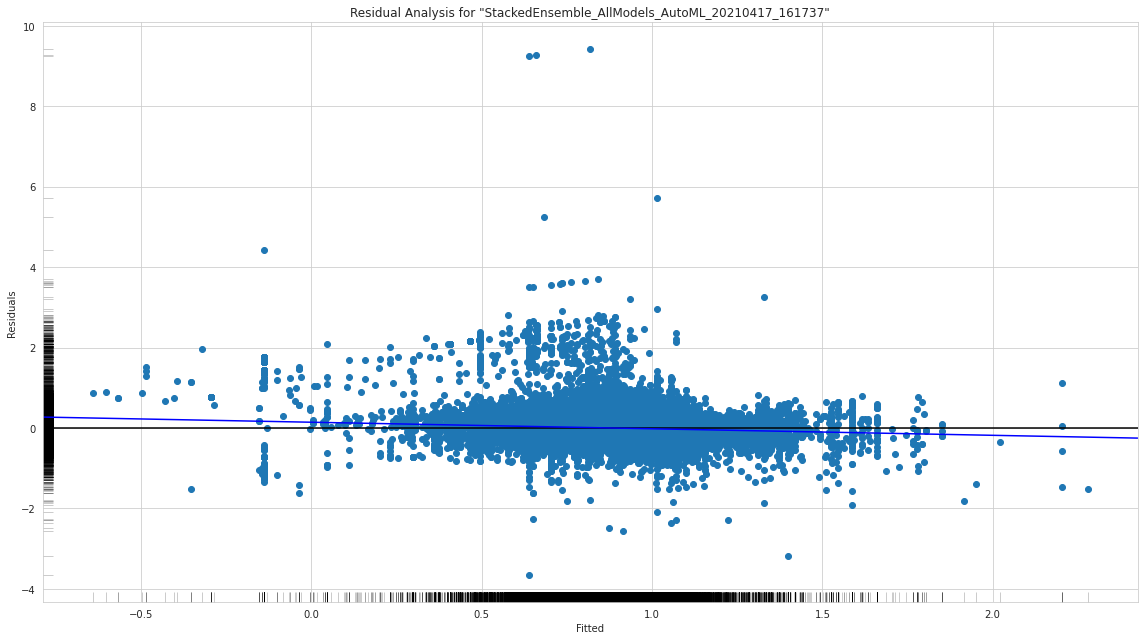

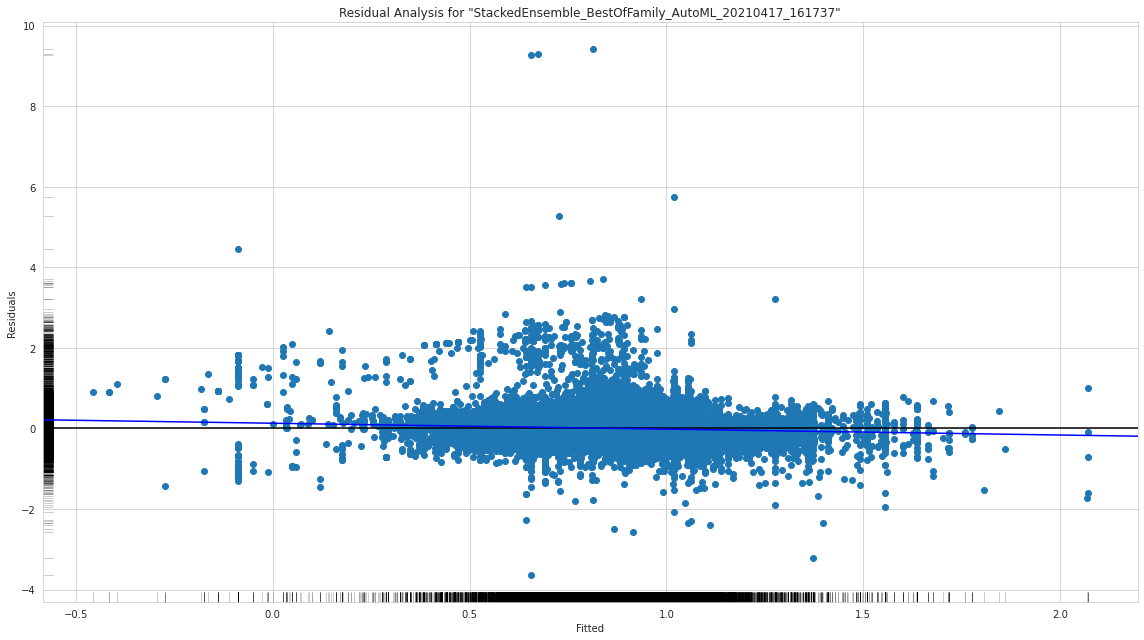

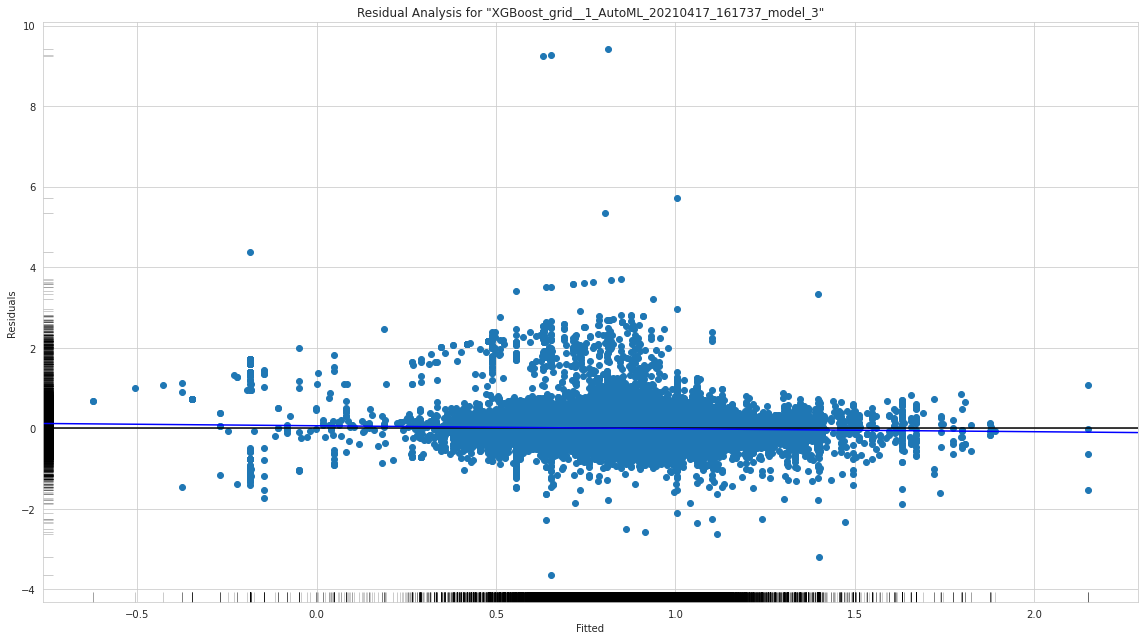

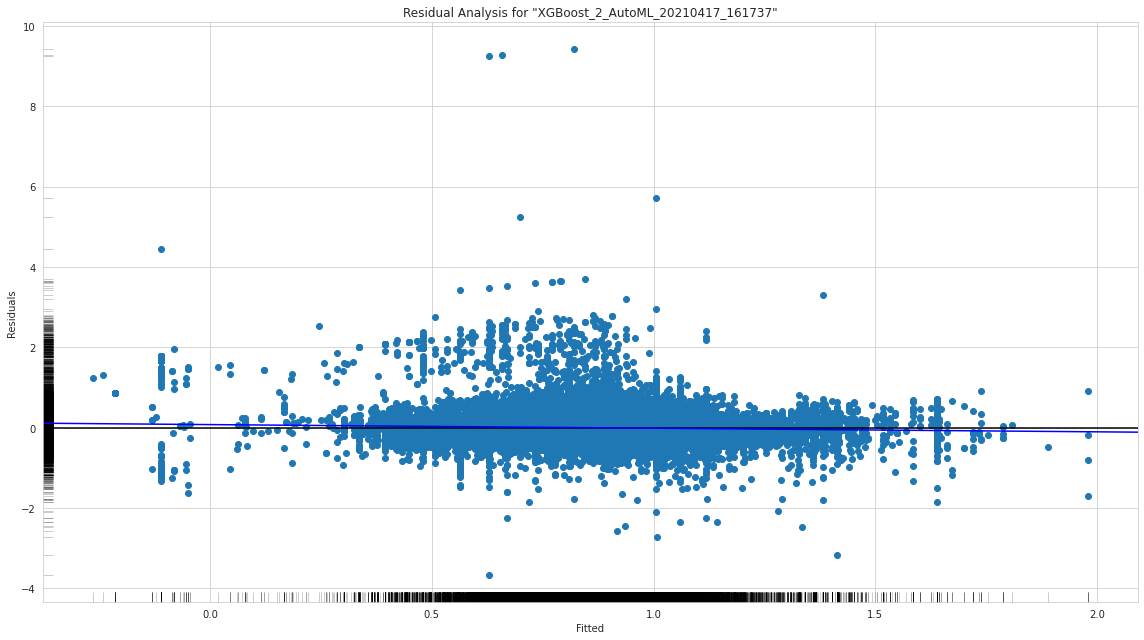

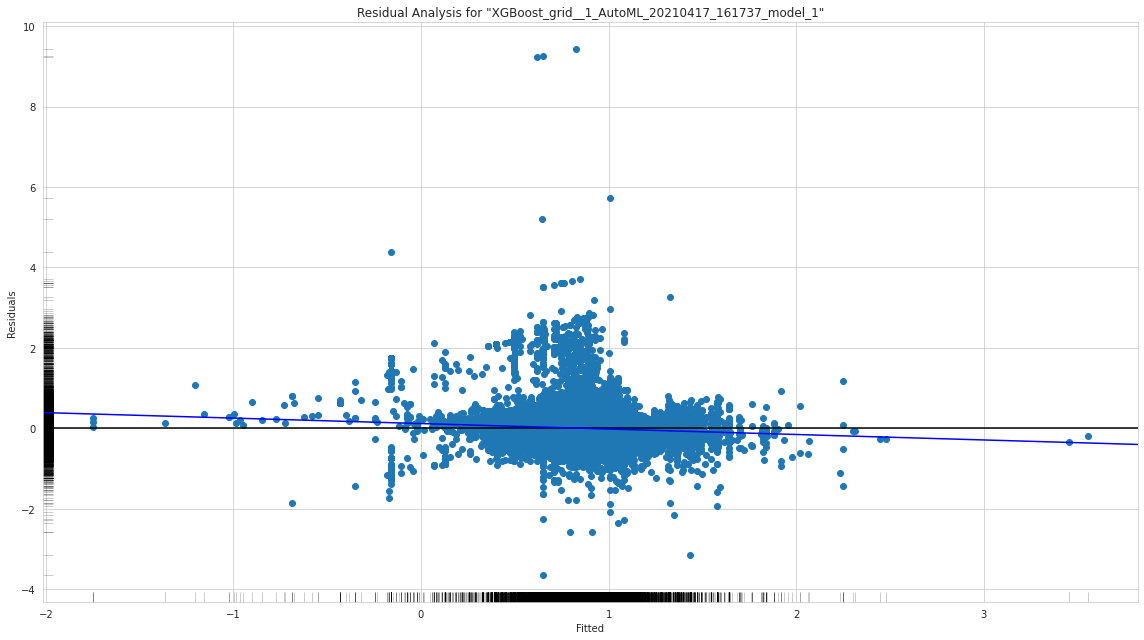

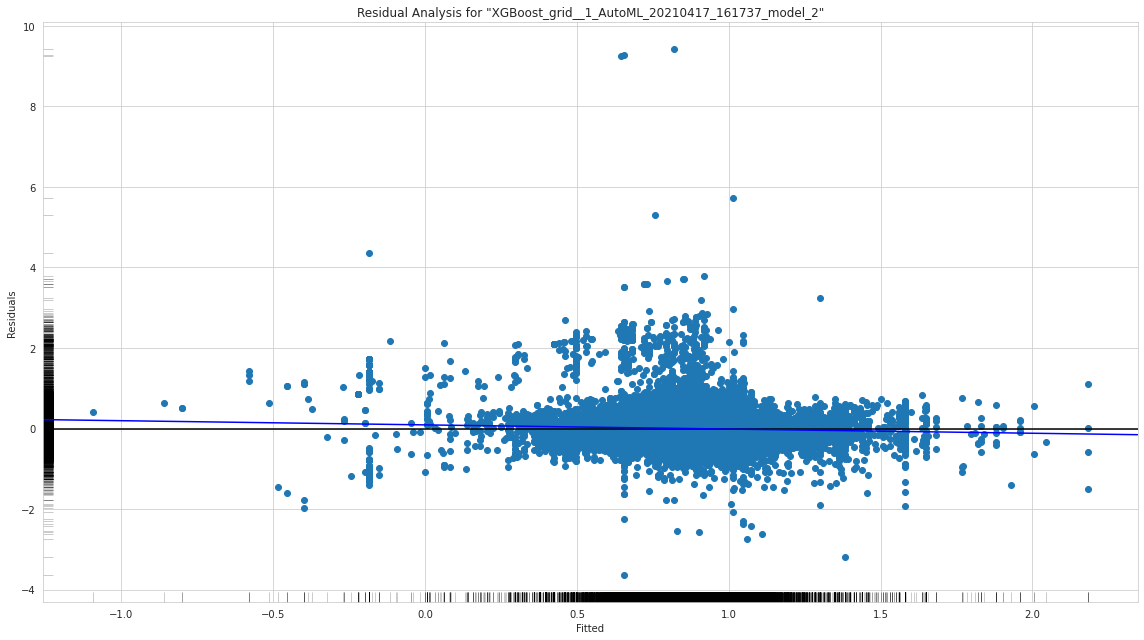

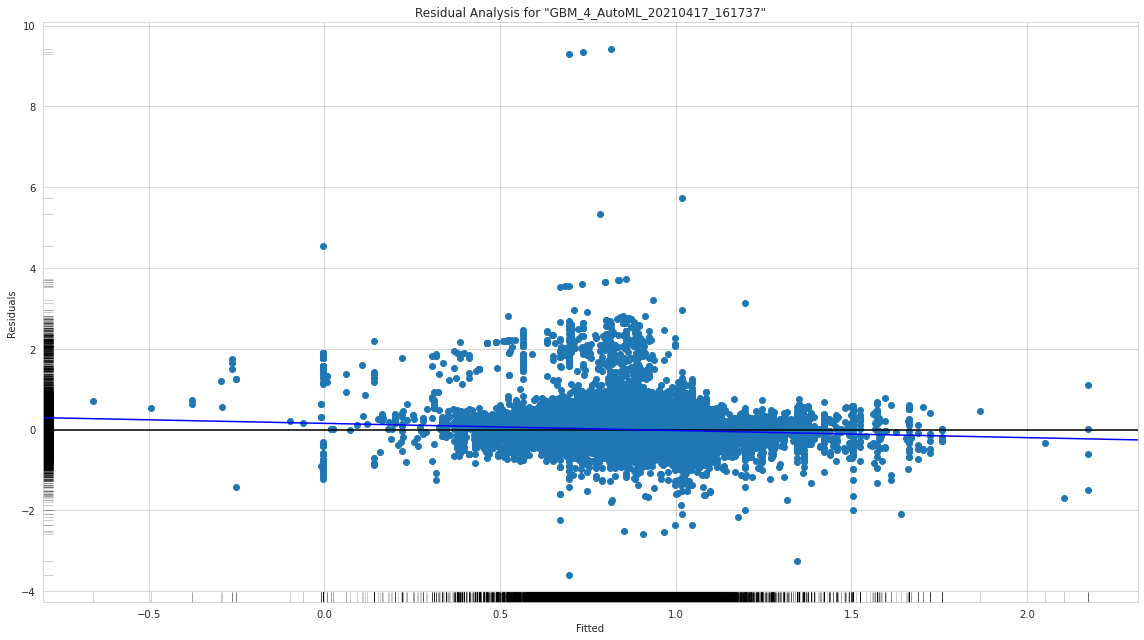

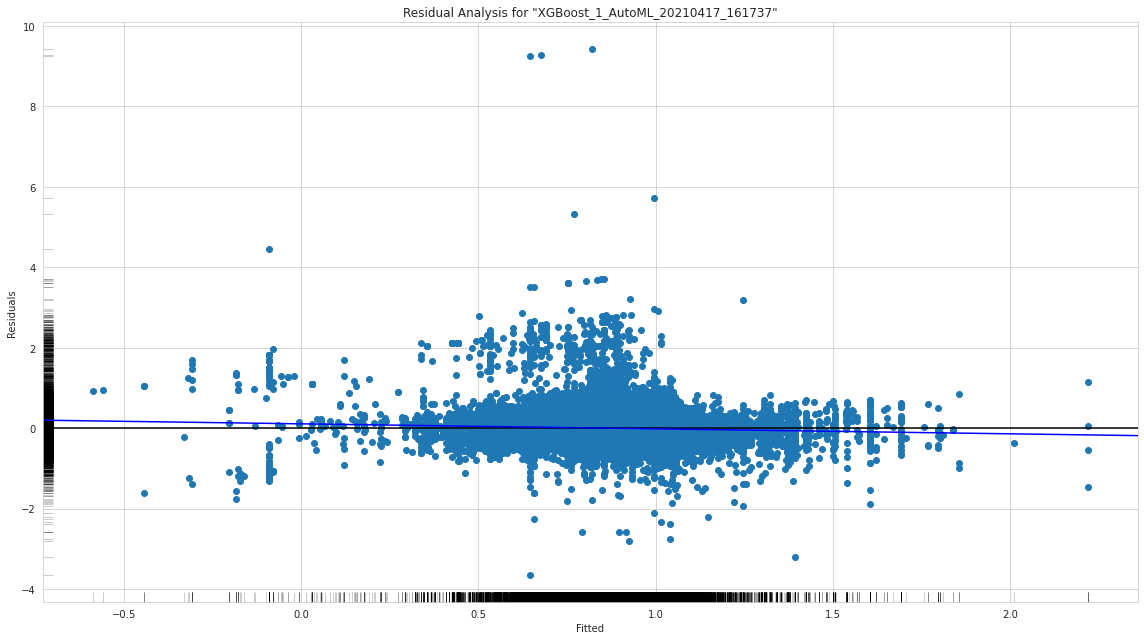

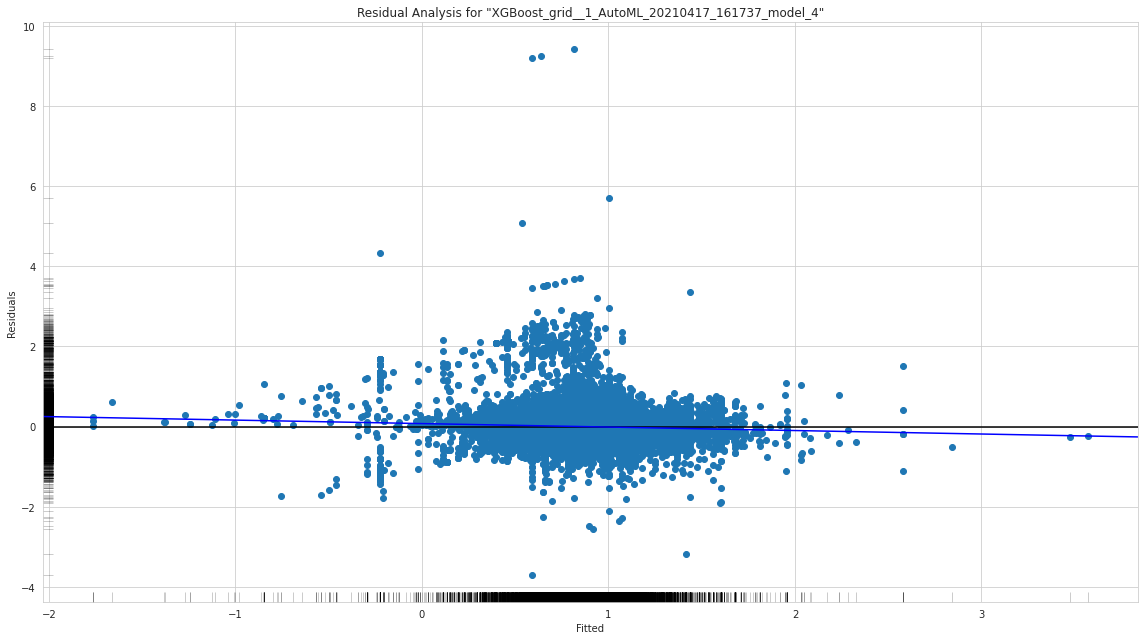

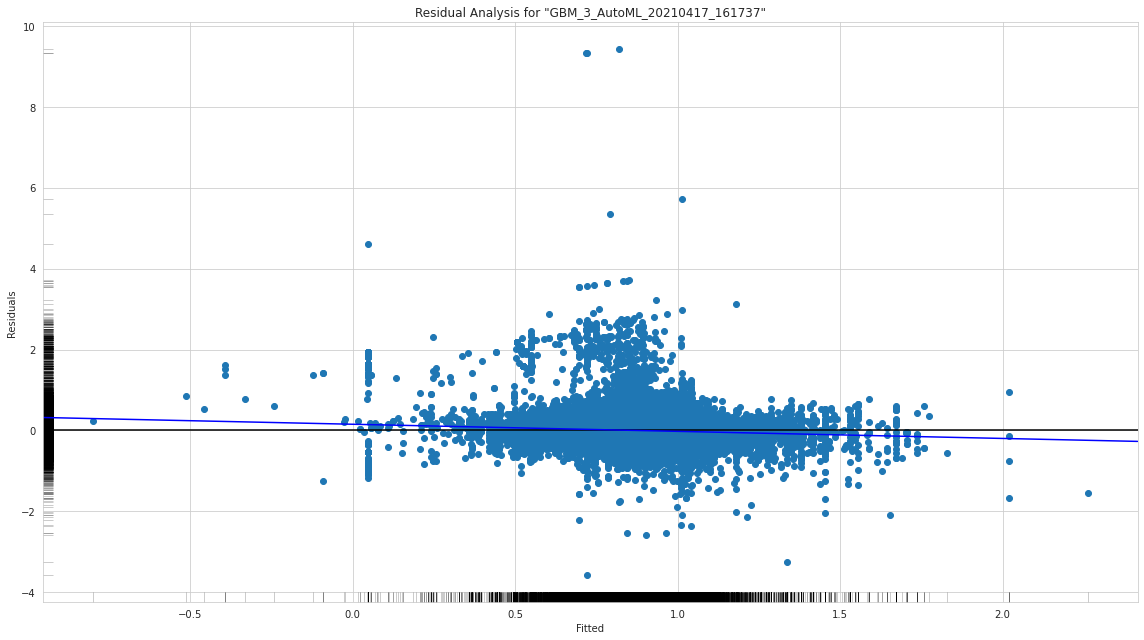

In [217]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.residual_analysis_plot(trainH2o)
    except:
        print ("plot attempt failed")

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

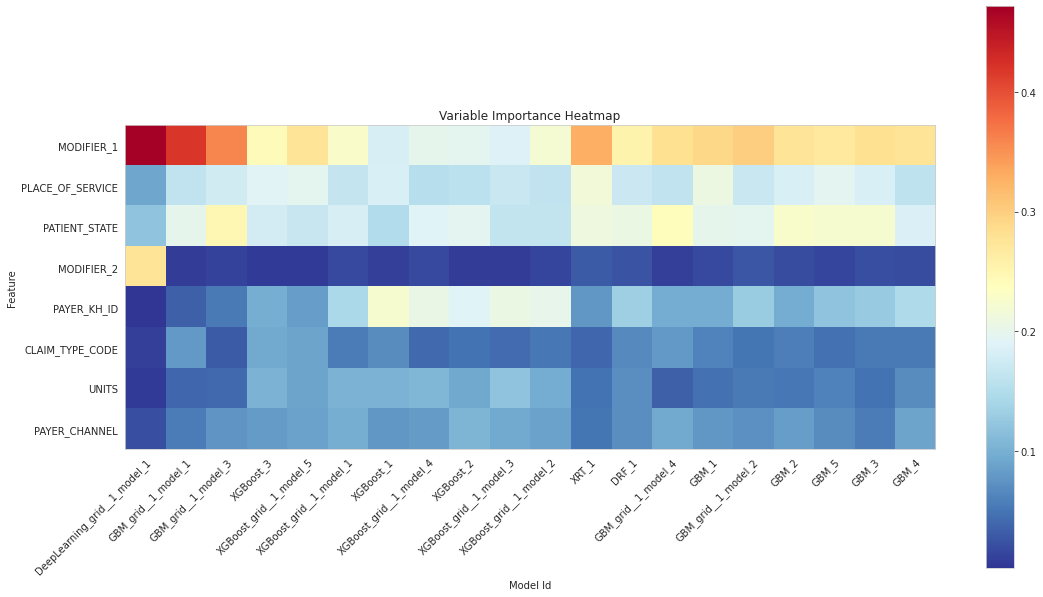

In [218]:
exa=aml.explain(trainH2o, include_explanations=["varimp_heatmap"])

In [215]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    yhat=temp.predict(testH2o).as_data_frame()
    temp_result=pd.concat([yhat["predict"].reset_index(), X_test.reset_index()], axis=1, ignore_index=True)
    temp_result.columns=["index1", "yhat", "index2"]+X_test.columns.to_list()
    mod_yhat=temp_result["yhat"]*log(temp_result["PROC_PRICE_MEAN"])
    temp_result["residual"]=mod_yhat-log(temp_result["ALLOWED_AMOUNT"])
    mse1=sqrt(mse(mod_yhat,log(temp_result["ALLOWED_AMOUNT"])))
    mse2=sqrt(mse(log(temp_result["PROC_PRICE_MEAN"]),log(temp_result["ALLOWED_AMOUNT"])))
    mse3=sqrt(mse(log(temp_result["GLOBAL_PRICE_MEAN"]),log(temp_result["ALLOWED_AMOUNT"])))
    print(mse1,mse2,mse3)


StackedEnsemble_AllModels_AutoML_20210417_161737
stackedensemble prediction progress: |████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


0.9958514526421793 1.2303931584554335 2.0784531432515854
StackedEnsemble_BestOfFamily_AutoML_20210417_161737
stackedensemble prediction progress: |████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


0.9973643863537487 1.2303931584554335 2.0784531432515854
XGBoost_grid__1_AutoML_20210417_161737_model_3
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


1.0077901464265953 1.2303931584554335 2.0784531432515854
XGBoost_2_AutoML_20210417_161737
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


1.00684179105957 1.2303931584554335 2.0784531432515854
XGBoost_grid__1_AutoML_20210417_161737_model_1
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


1.010889838841739 1.2303931584554335 2.0784531432515854
XGBoost_grid__1_AutoML_20210417_161737_model_2
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


1.010465272998372 1.2303931584554335 2.0784531432515854
GBM_4_AutoML_20210417_161737
gbm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


1.0064387497533611 1.2303931584554335 2.0784531432515854
XGBoost_1_AutoML_20210417_161737
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


1.0099525733636554 1.2303931584554335 2.0784531432515854
XGBoost_grid__1_AutoML_20210417_161737_model_4
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


1.024022174293471 1.2303931584554335 2.0784531432515854
GBM_3_AutoML_20210417_161737
gbm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""63"", ""A3"", ""AK"", ""AY"", ""CD"", ""DS"", ""G6"", ""GQ"", ""L2"", ...4 not listed..., ""Q2"", ""Q7"", ""SI"", ""SU"", ""T2"", ""TK"", ""UQ"", ""UR"", ""US"", ""V1""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""32"", ""A4"", ""AA"", ""BA"", ""EH"", ""FA"", ""FX"", ""G8"", ""GG"", ""GM"", ...6 not listed..., ""MG"", ""MS"", ""PR"", ""QM"", ""QY"", ""SL"", ""T9"", ""TB"", ""X1"", ""X4""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""18"", ""25""]
  warnings.warn(w)


1.0095843175603858 1.2303931584554335 2.0784531432515854


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


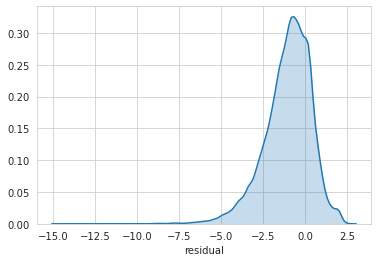

In [220]:
sns.distplot(log(temp_result["residual"]),
         kde_kws={"shade": True}, hist=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/opt/conda/lib/python3.7/site-packages/ipykernel

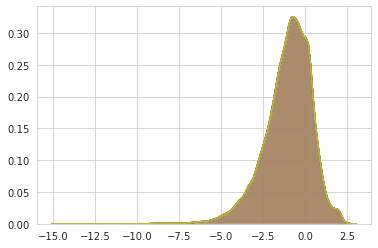

In [223]:
soc_list = temp_result['VISIT_SETTING_OF_CARE'].unique()  
pd_list = [temp_result.loc[temp_result['VISIT_SETTING_OF_CARE'] == soc] for soc in soc_list]

for pd_temp in pd_list:
    sns.distplot(log(temp_result[['residual']]), kde_kws={"shade": True},hist=False)

[Text(0, 0, 'Outpatient Visit'),
 Text(0, 0, 'Home Visit'),
 Text(0, 0, 'Laboratory Visit'),
 Text(0, 0, 'Inpatient Visit'),
 Text(0, 0, 'Emergency Room Visit'),
 Text(0, 0, 'Ambulance Visit'),
 Text(0, 0, 'Non-hospital institution Visit'),
 Text(0, 0, 'Pharmacy Visit')]

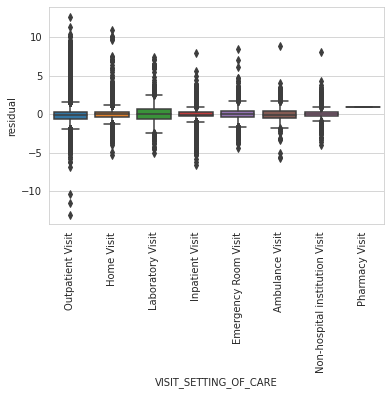

In [231]:
g=sns.boxplot(x="VISIT_SETTING_OF_CARE", y="residual", data=temp_result)

g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [224]:
pd_list[0].head()

,index1,yhat,index2,PROCEDURE,PATIENT_STATE,PAYER_KH_ID,PAYER_CHANNEL,CLAIM_TYPE_CODE,MODIFIER_1,MODIFIER_2,UNITS,PLACE_OF_SERVICE,VISIT_SETTING_OF_CARE,ALLOWED_AMOUNT,PROC_PRICE_MEAN,GLOBAL_PRICE_MEAN,LOG_ALLOWED_AMOUNT_CENTER,residual
0,0,0.875429,34713,"""28190""",NY,328,Managed Medicaid,P,"""LT""",None,1,"""11""",Outpatient Visit,182.00,301.675000,183.466628,0.911488,-0.205877
5,5,0.934715,43221,"""92551""",MA,244,Commercial,P,None,None,1,"""11""",Outpatient Visit,25.00,28.226290,183.466628,0.963662,-0.096691
6,6,0.820826,146449,"""92014""",TX,266,Commercial,P,None,None,1,"""11""",Outpatient Visit,59.00,123.792704,183.466628,0.846206,-0.122300
7,7,0.806377,73855,"""85025""",TX,73,Managed Medicaid,P,None,None,None,"""11""",Outpatient Visit,7.25,47.773766,183.466628,0.512353,1.136837
10,10,0.964611,27815,"""93460""",OH,186,Commercial,I,None,None,1,None,Outpatient Visit,10812.56,919.090769,183.466628,1.361269,-2.706552


In [225]:
pd_list[1].head()

,index1,yhat,index2,PROCEDURE,PATIENT_STATE,PAYER_KH_ID,PAYER_CHANNEL,CLAIM_TYPE_CODE,MODIFIER_1,MODIFIER_2,UNITS,PLACE_OF_SERVICE,VISIT_SETTING_OF_CARE,ALLOWED_AMOUNT,PROC_PRICE_MEAN,GLOBAL_PRICE_MEAN,LOG_ALLOWED_AMOUNT_CENTER,residual
1,1,0.889628,32366,"""S9131""",AR,186,Commercial,I,None,None,1,None,Home Visit,134.00,137.771818,183.466628,0.994364,-0.515887
4,4,1.005210,8478,"""T4527""",TX,251,Managed Medicaid,P,None,None,240,"""12""",Home Visit,117.60,75.606304,183.466628,1.102126,-0.419213
78,78,0.952818,185945,"""A7038""",CA,186,Commercial,P,"""NU""","""KX""",3,"""12""",Home Visit,12.39,10.097051,183.466628,1.088506,-0.313742
85,85,0.824861,183446,"""G0299""",LA,21,Commercial,I,None,None,1,None,Home Visit,115.00,175.525243,183.466628,0.918176,-0.482231
92,92,0.984680,159408,"""W1793""",PA,70,Managed Medicaid,P,None,None,48,"""12""",Home Visit,239.04,168.793057,183.466628,1.067846,-0.426529


In [221]:
temp_result.columns

Index(['index1', 'yhat', 'index2', 'PROCEDURE', 'PATIENT_STATE', 'PAYER_KH_ID',
       'PAYER_CHANNEL', 'CLAIM_TYPE_CODE', 'MODIFIER_1', 'MODIFIER_2', 'UNITS',
       'PLACE_OF_SERVICE', 'VISIT_SETTING_OF_CARE', 'ALLOWED_AMOUNT',
       'PROC_PRICE_MEAN', 'GLOBAL_PRICE_MEAN', 'LOG_ALLOWED_AMOUNT_CENTER',
       'residual'],
      dtype='object')

In [216]:
for model_name in model_ids:
    model=h2o.get_model(model_name)
    model_path = h2o.save_model(model=model, path="dev/costofcare/analysis/h2o_models/", force=True)
    print (model_path)

/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/StackedEnsemble_AllModels_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/StackedEnsemble_BestOfFamily_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210417_161737_model_3
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_2_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210417_161737_model_1
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210417_161737_model_2
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/GBM_4_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_1_AutoML_20210417_161737
/home/jovyan/dev/costofcare/analysis/dev/costofcare/analysis/h2o_models/XGBoost_grid__1

#### Run Basic Model w/SOC

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_model,
                                                    X_model[yName],
                                                    test_size=0.5, random_state=0)

In [13]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_runtime_secs=7200, seed=1)
trainH2o=h2o.H2OFrame(pd.concat([y_train,X_train[xNames_1] ], axis=1))
testH2o=h2o.H2OFrame(pd.concat([y_test,X_test[xNames_1]], axis=1))
aml.train(x=xNames_1, y=yName, training_frame=trainH2o,
          validation_frame=testH2o,leaderboard_frame=testH2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
20:48:59.551: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [14]:
aml.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20210418_204859,0.111169,0.33342,0.111169,0.154233,nan
XGBoost_grid__1_AutoML_20210418_204859_model_87,0.111527,0.333956,0.111527,0.154193,nan
XGBoost_grid__1_AutoML_20210418_204859_model_16,0.112312,0.33513,0.112312,0.154704,nan
StackedEnsemble_AllModels_AutoML_20210418_204859,0.112486,0.33539,0.112486,0.154043,nan
GBM_5_AutoML_20210418_204859,0.113134,0.336353,0.113134,0.158345,nan
XGBoost_grid__1_AutoML_20210418_204859_model_71,0.113136,0.336357,0.113136,0.156835,nan
XGBoost_grid__1_AutoML_20210418_204859_model_56,0.113568,0.336998,0.113568,0.156636,nan
DRF_1_AutoML_20210418_204859,0.113759,0.337281,0.113759,0.157132,nan
GBM_grid__1_AutoML_20210418_204859_model_5,0.113876,0.337456,0.113876,0.157441,nan
XGBoost_grid__1_AutoML_20210418_204859_model_29,0.113889,0.337475,0.113889,0.157673,nan


In [15]:
model_ids=aml.leaderboard.as_data_frame()["model_id"].tolist()

In [16]:
model_ids

['StackedEnsemble_BestOfFamily_AutoML_20210418_204859',
 'XGBoost_grid__1_AutoML_20210418_204859_model_87',
 'XGBoost_grid__1_AutoML_20210418_204859_model_16',
 'StackedEnsemble_AllModels_AutoML_20210418_204859',
 'GBM_5_AutoML_20210418_204859',
 'XGBoost_grid__1_AutoML_20210418_204859_model_71',
 'XGBoost_grid__1_AutoML_20210418_204859_model_56',
 'DRF_1_AutoML_20210418_204859',
 'GBM_grid__1_AutoML_20210418_204859_model_5',
 'XGBoost_grid__1_AutoML_20210418_204859_model_29',
 'XGBoost_grid__1_AutoML_20210418_204859_model_38',
 'XGBoost_grid__1_AutoML_20210418_204859_model_107',
 'GBM_grid__1_AutoML_20210418_204859_model_35',
 'GBM_grid__1_AutoML_20210418_204859_model_37',
 'GBM_grid__1_AutoML_20210418_204859_model_17',
 'GBM_grid__1_AutoML_20210418_204859_model_29',
 'XGBoost_grid__1_AutoML_20210418_204859_model_40',
 'XGBoost_grid__1_AutoML_20210418_204859_model_51',
 'GBM_grid__1_AutoML_20210418_204859_model_4',
 'XGBoost_grid__1_AutoML_20210418_204859_model_9',
 'XGBoost_grid__1_A

StackedEnsemble_BestOfFamily_AutoML_20210418_204859
plot attempt failed
XGBoost_grid__1_AutoML_20210418_204859_model_87


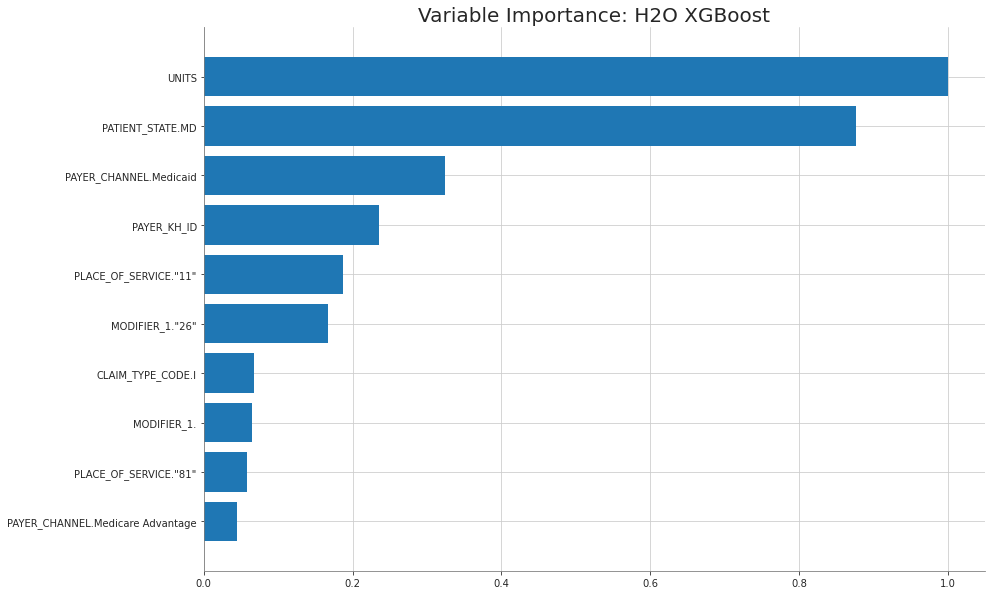

XGBoost_grid__1_AutoML_20210418_204859_model_16


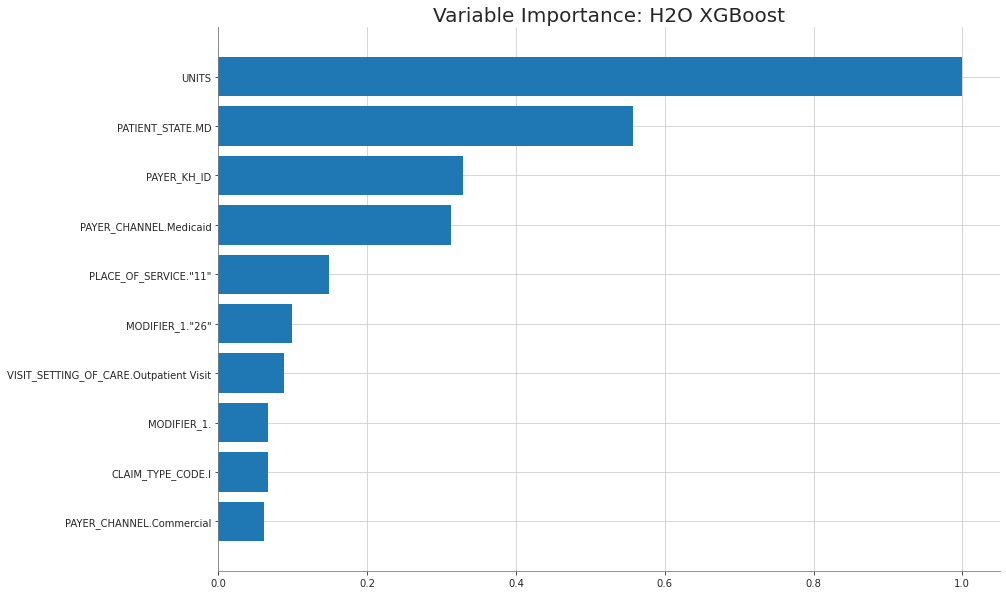

StackedEnsemble_AllModels_AutoML_20210418_204859
plot attempt failed
GBM_5_AutoML_20210418_204859


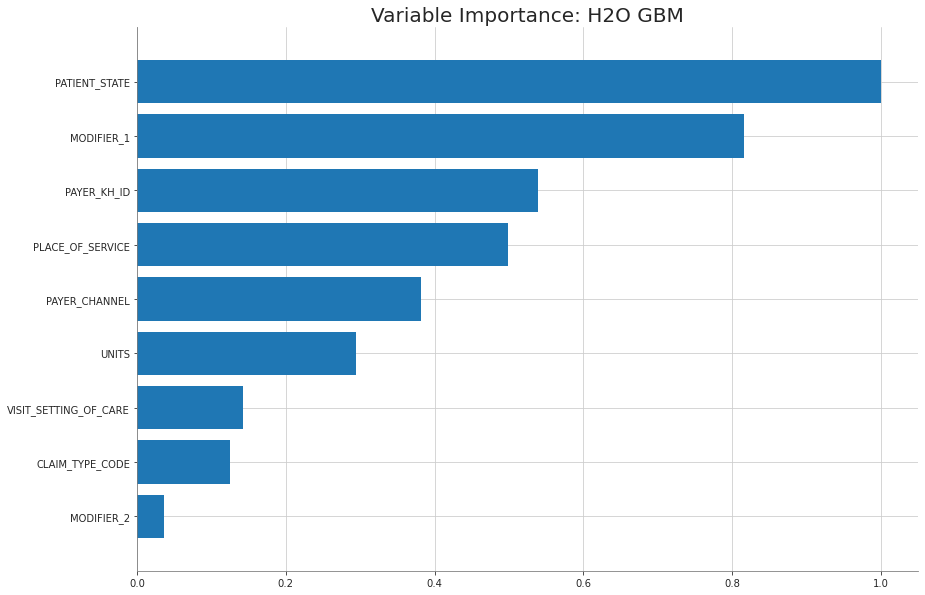

XGBoost_grid__1_AutoML_20210418_204859_model_71


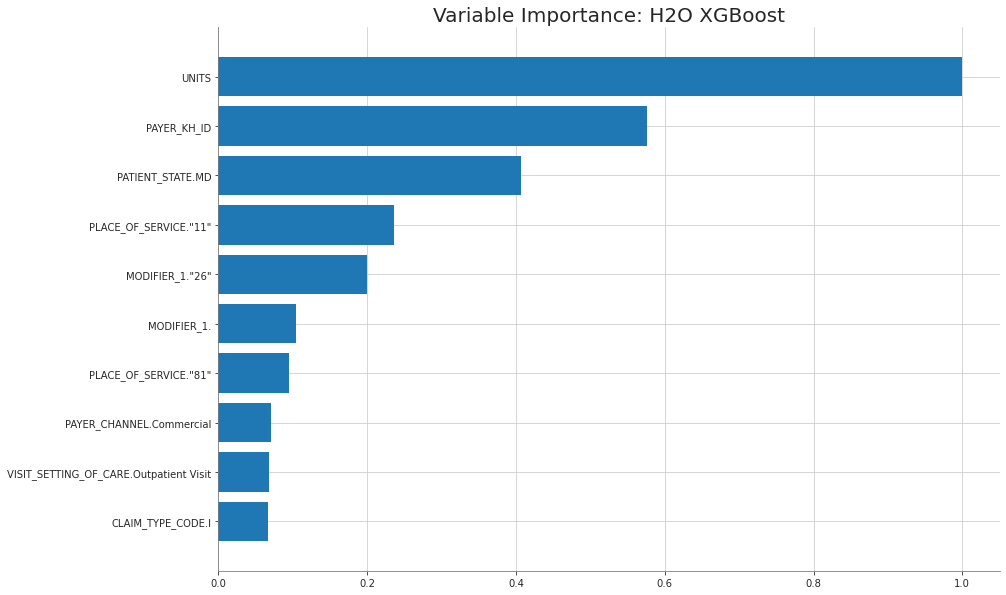

XGBoost_grid__1_AutoML_20210418_204859_model_56


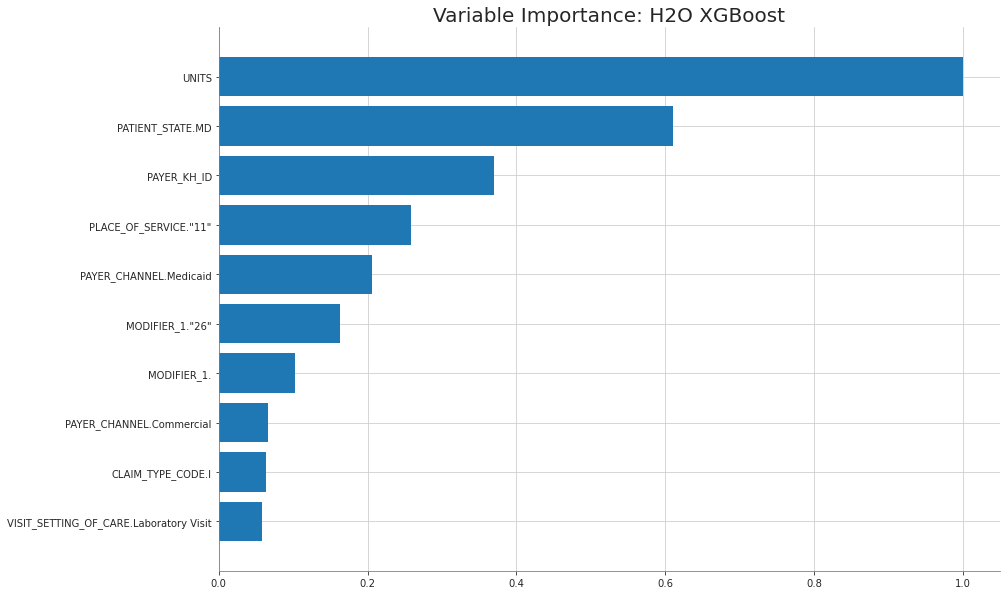

DRF_1_AutoML_20210418_204859


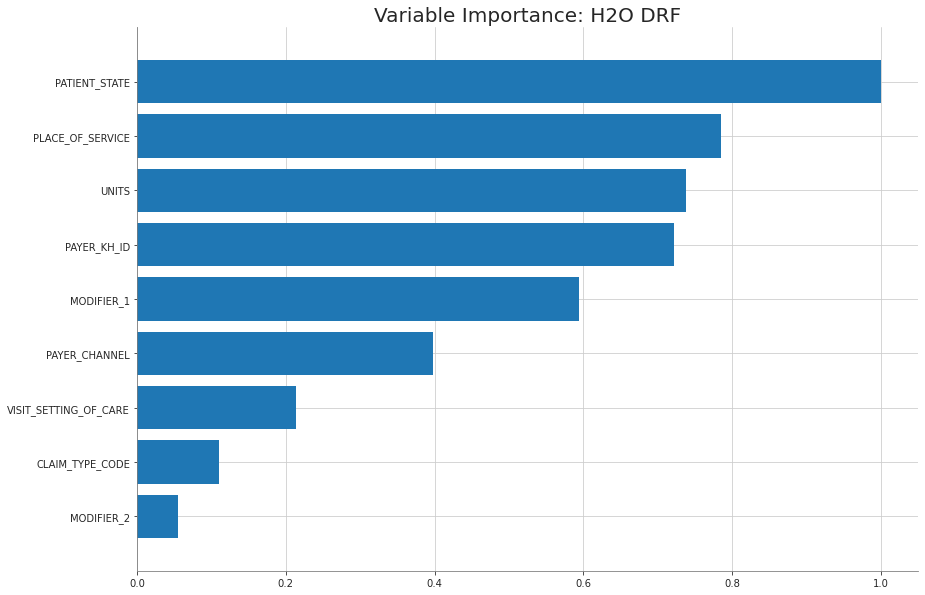

GBM_grid__1_AutoML_20210418_204859_model_5


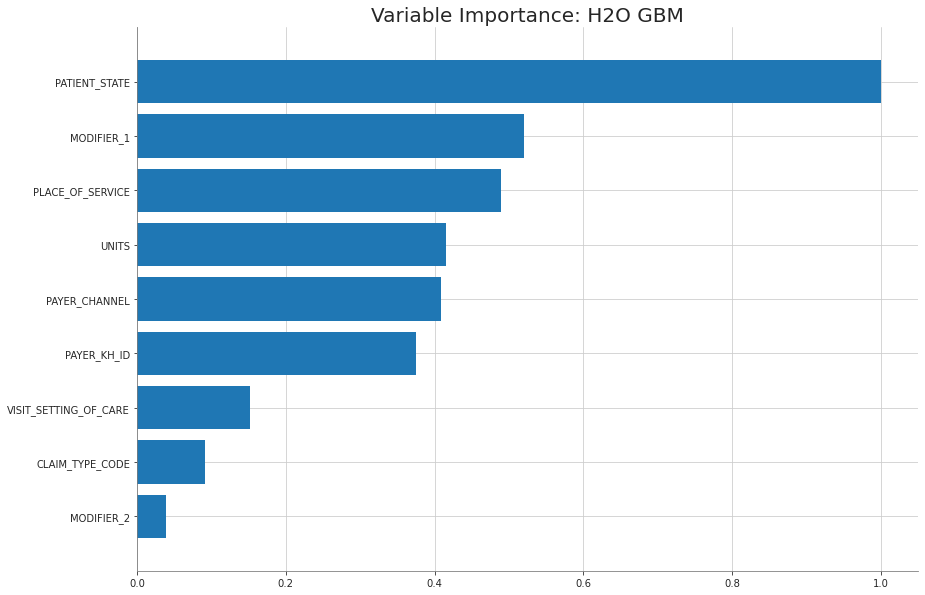

XGBoost_grid__1_AutoML_20210418_204859_model_29


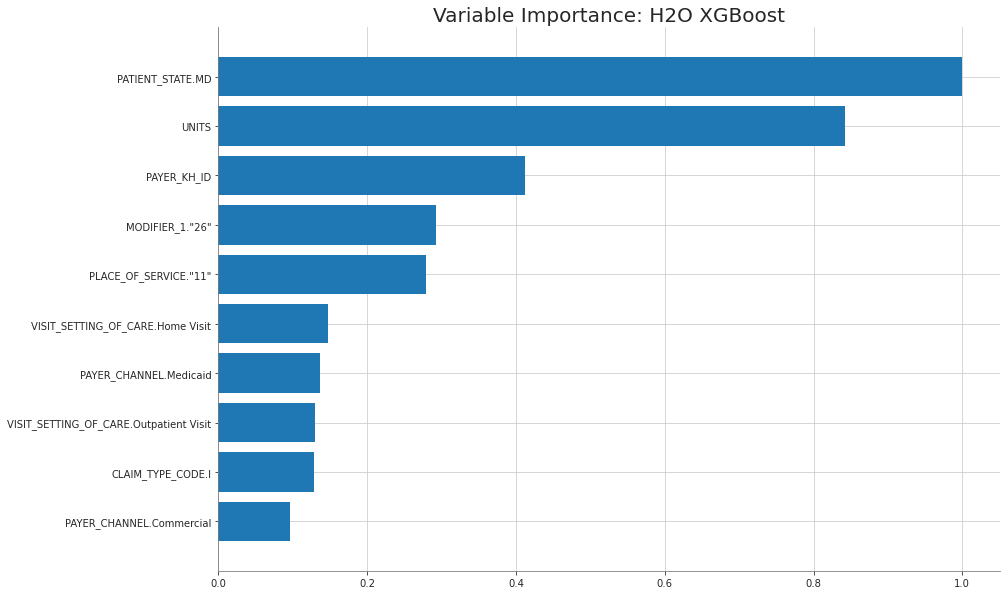

In [17]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.varimp_plot()
    except:
        print ("plot attempt failed")

StackedEnsemble_BestOfFamily_AutoML_20210418_204859
XGBoost_grid__1_AutoML_20210418_204859_model_87
XGBoost_grid__1_AutoML_20210418_204859_model_16
StackedEnsemble_AllModels_AutoML_20210418_204859
GBM_5_AutoML_20210418_204859
XGBoost_grid__1_AutoML_20210418_204859_model_71
XGBoost_grid__1_AutoML_20210418_204859_model_56
DRF_1_AutoML_20210418_204859
GBM_grid__1_AutoML_20210418_204859_model_5
XGBoost_grid__1_AutoML_20210418_204859_model_29


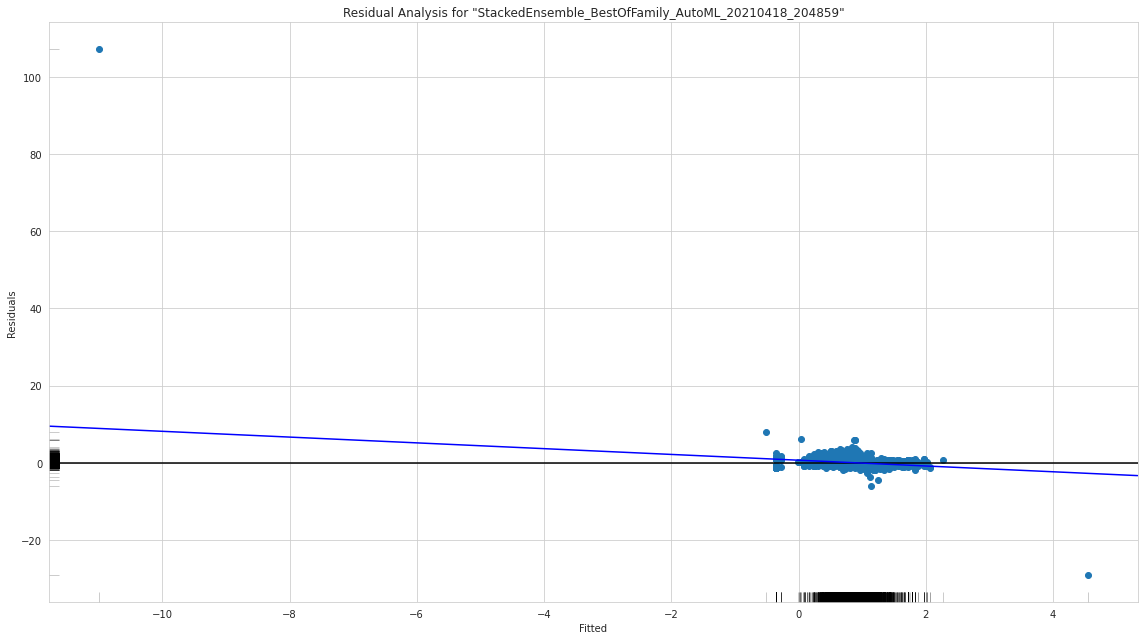

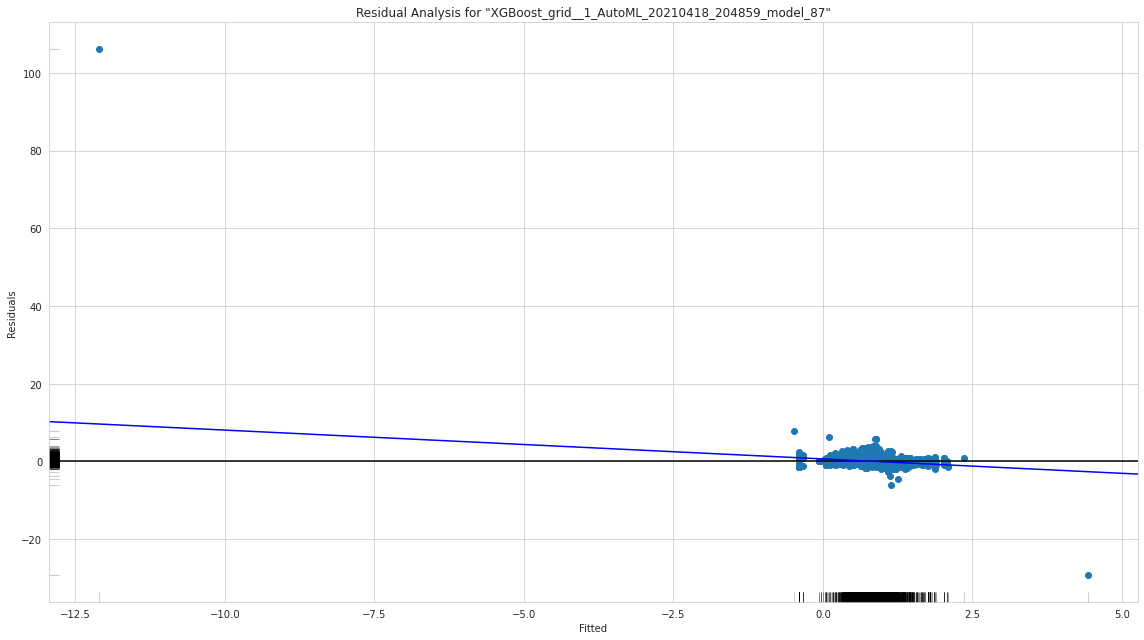

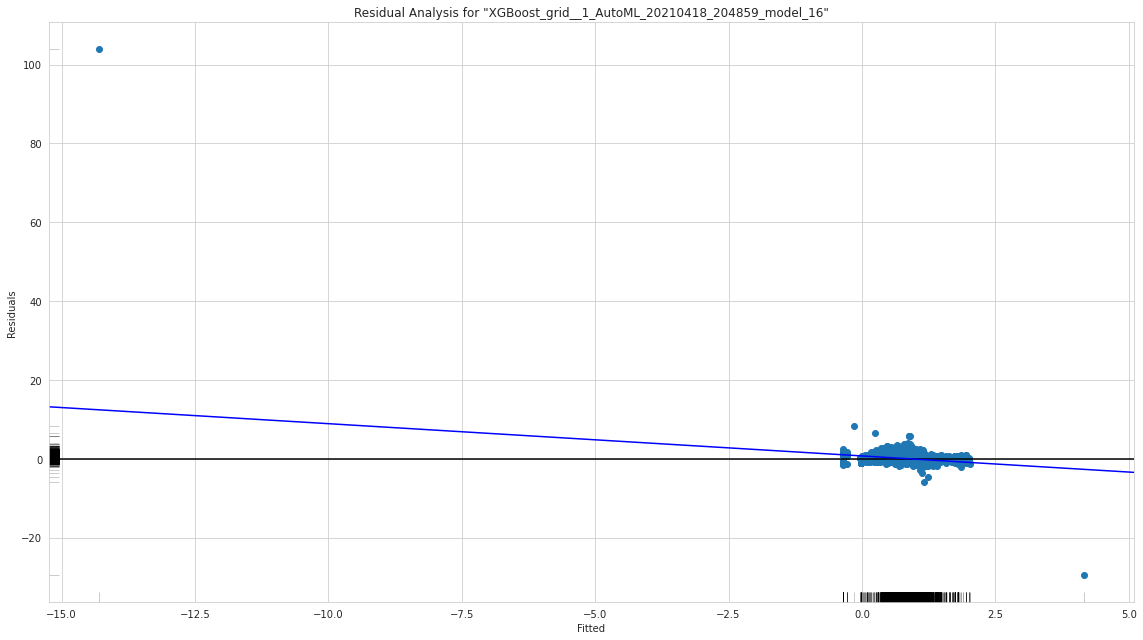

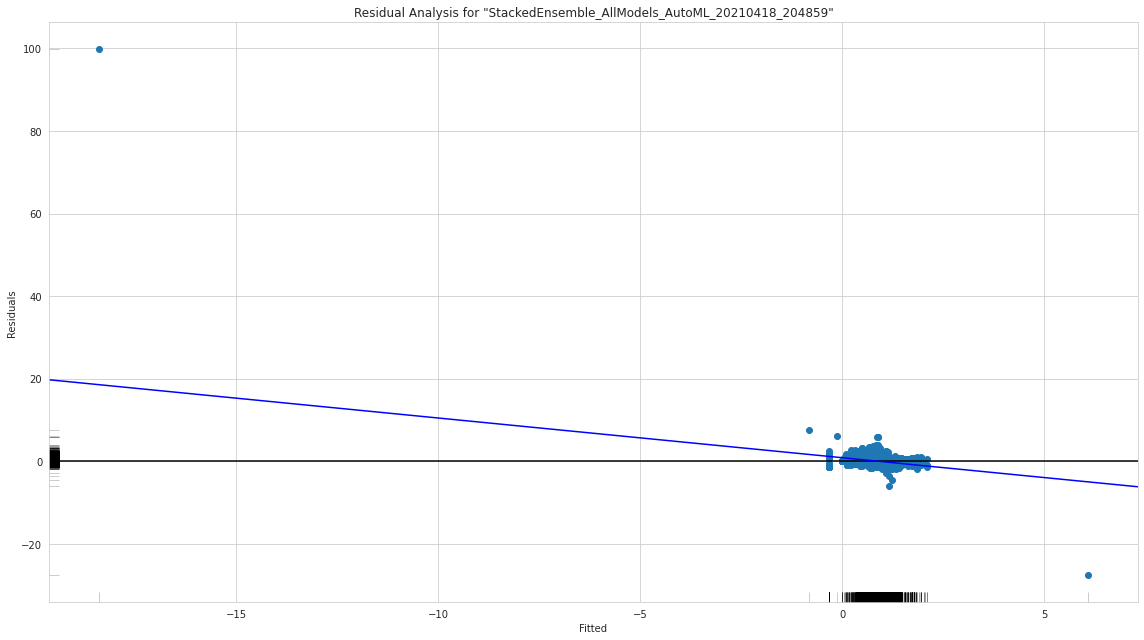

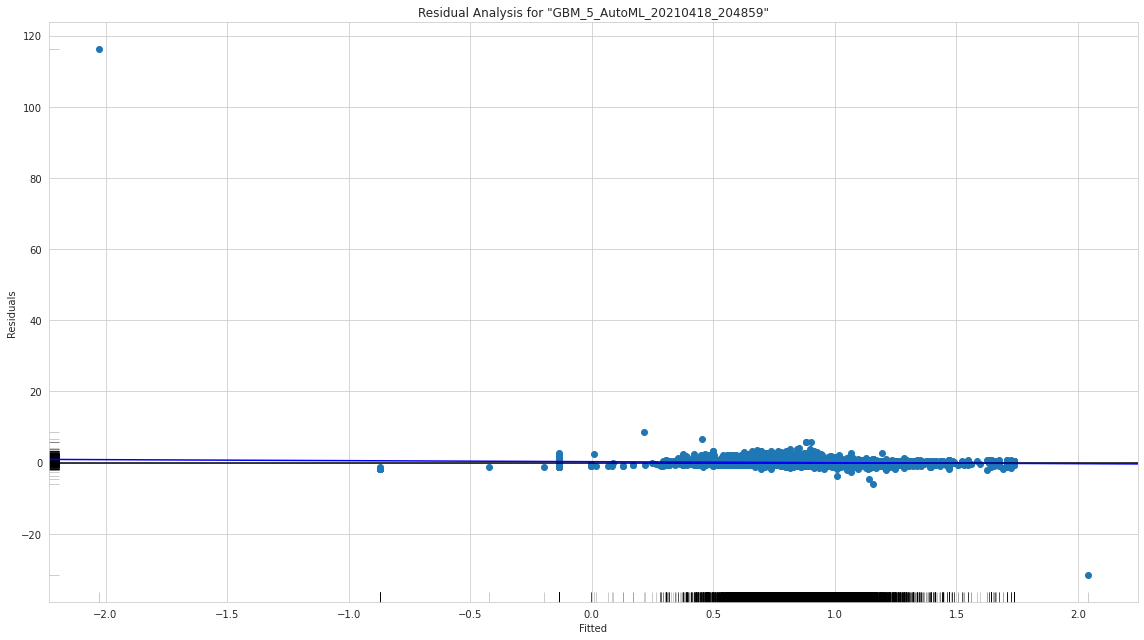

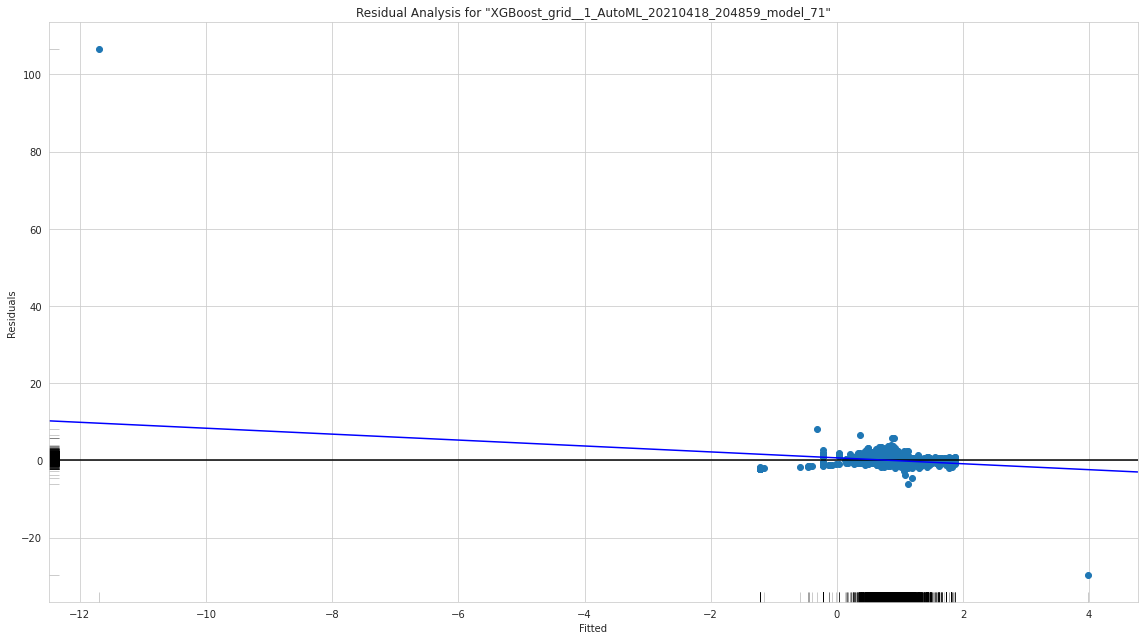

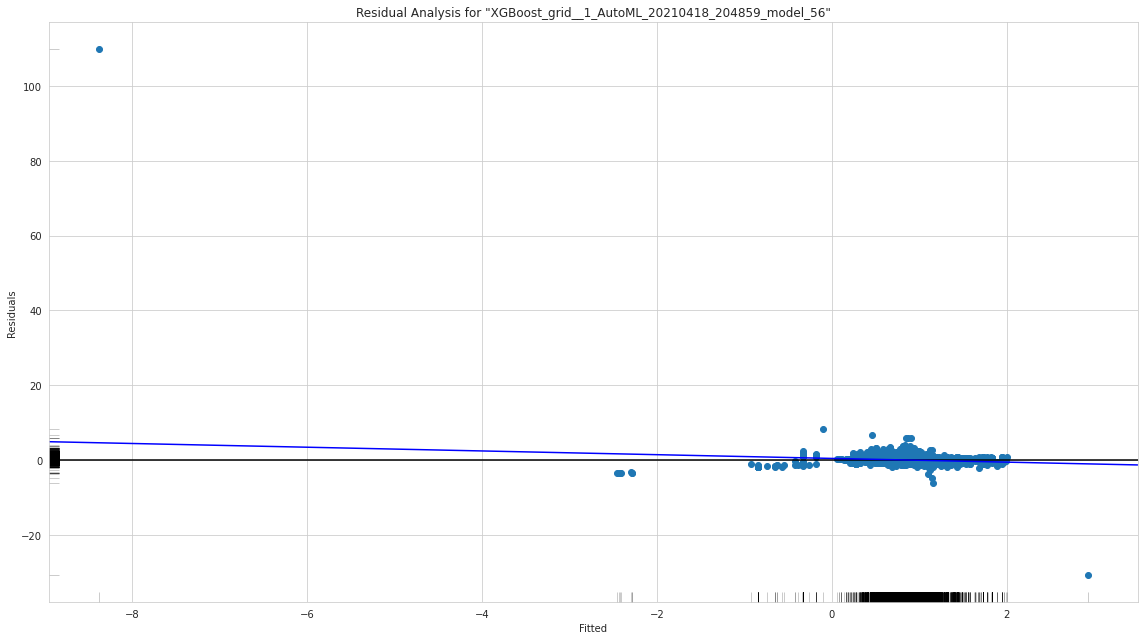

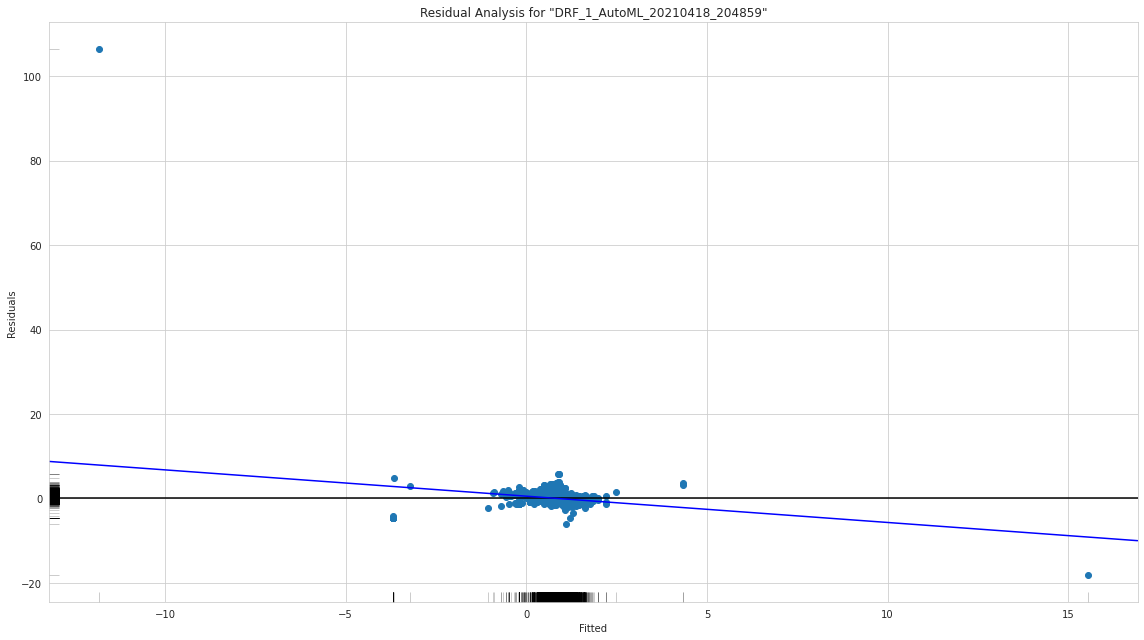

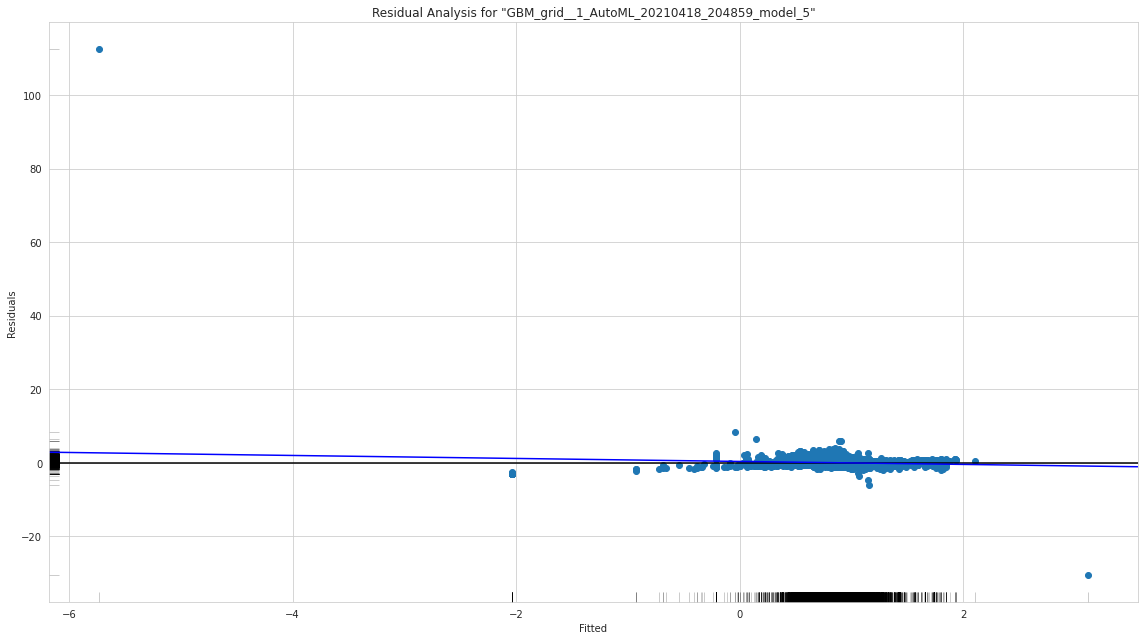

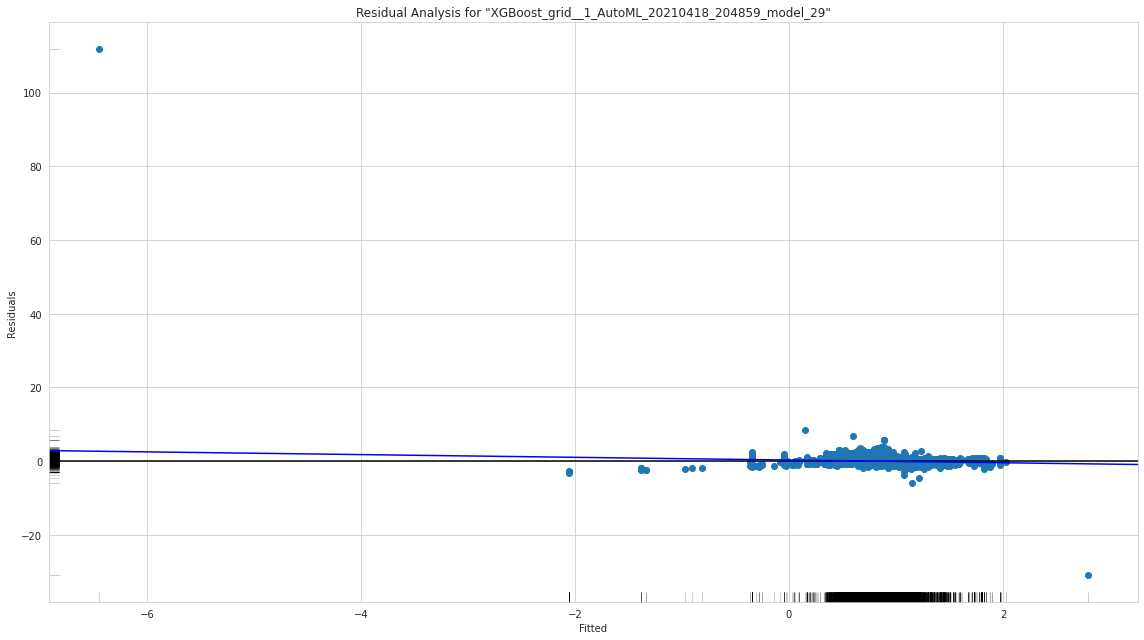

In [18]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    try:
        temp.residual_analysis_plot(trainH2o)
    except:
        print ("plot attempt failed")

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

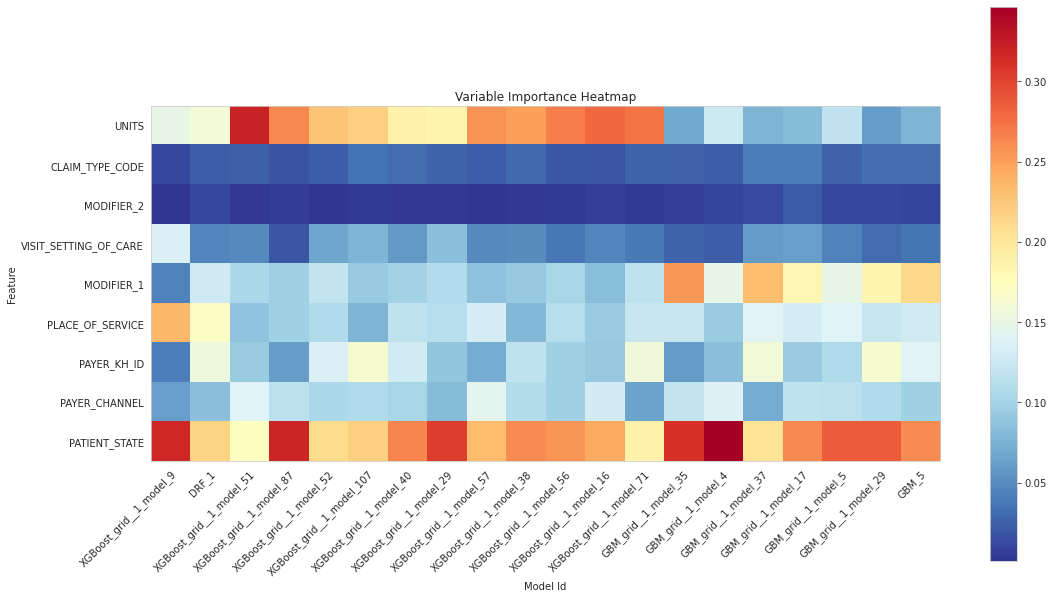

In [19]:
exa=aml.explain(trainH2o, include_explanations=["varimp_heatmap"])

In [20]:
for model in model_ids[:10]:
    temp=h2o.get_model(model)
    print (model)
    yhat=temp.predict(testH2o).as_data_frame()
    temp_result=pd.concat([yhat["predict"].reset_index(), X_test.reset_index()], axis=1, ignore_index=True)
    temp_result.columns=["index1", "yhat", "index2"]+X_test.columns.to_list()
    mod_yhat=temp_result["yhat"]*log(temp_result["PROC_PRICE_MEAN"])
    temp_result["residual"]=mod_yhat-log(temp_result["ALLOWED_AMOUNT"])
    mse1=sqrt(mse(mod_yhat,log(temp_result["ALLOWED_AMOUNT"])))
    mse2=sqrt(mse(log(temp_result["PROC_PRICE_MEAN"]),log(temp_result["ALLOWED_AMOUNT"])))
    mse3=sqrt(mse(log(temp_result["GLOBAL_PRICE_MEAN"]),log(temp_result["ALLOWED_AMOUNT"])))
    print(mse1,mse2,mse3)


StackedEnsemble_BestOfFamily_AutoML_20210418_204859
stackedensemble prediction progress: |████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0057350041876618 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_87
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0095268940176954 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_16
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0153327276731174 1.2259589918412097 2.049179482039793
StackedEnsemble_AllModels_AutoML_20210418_204859
stackedensemble prediction progress: |████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0163254697157935 1.2259589918412097 2.049179482039793
GBM_5_AutoML_20210418_204859
gbm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0208746824376662 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_71
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0214797055375981 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_56
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0286545350524865 1.2259589918412097 2.049179482039793
DRF_1_AutoML_20210418_204859
drf prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0389327475323553 1.2259589918412097 2.049179482039793
GBM_grid__1_AutoML_20210418_204859_model_5
gbm prediction progress: |████████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0328487280763654 1.2259589918412097 2.049179482039793
XGBoost_grid__1_AutoML_20210418_204859_model_29
xgboost prediction progress: |████████████████████████████████████████████| 100%


/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_1' has levels not trained on: [""1A"", ""1B"", ""AE"", ""AY"", ""DH"", ""F4"", ""G2"", ""GQ"", ""HU"", ""HX"", ...10 not listed..., ""Q7"", ""QN"", ""RI"", ""SD"", ""SI"", ""SQ"", ""SU"", ""UR"", ""V1"", ""X3""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'MODIFIER_2' has levels not trained on: [""53"", ""55"", ""57"", ""81"", ""A4"", ""AJ"", ""CJ"", ""E1"", ""E3"", ""E4"", ...6 not listed..., ""NP"", ""RJ"", ""SF"", ""SL"", ""ST"", ""T5"", ""T8"", ""TS"", ""U9"", ""UK""]
  warnings.warn(w)
/opt/conda/lib/python3.7/site-packages/h2o/job.py:72: UserWarning: Test/Validation dataset column 'PLACE_OF_SERVICE' has levels not trained on: [""05"", ""07"", ""08"", ""26""]
  warnings.warn(w)


1.0322032392741047 1.2259589918412097 2.049179482039793


In [26]:
for model_name in model_ids:
    model=h2o.get_model(model_name)
    model_path = h2o.save_model(model=model, path="h2o_models/", force=True)
    print (model_path)

/home/jovyan/dev/costofcare/analysis/h2o_models/StackedEnsemble_BestOfFamily_AutoML_20210418_204859
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_87
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_16
/home/jovyan/dev/costofcare/analysis/h2o_models/StackedEnsemble_AllModels_AutoML_20210418_204859
/home/jovyan/dev/costofcare/analysis/h2o_models/GBM_5_AutoML_20210418_204859
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_71
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_56
/home/jovyan/dev/costofcare/analysis/h2o_models/DRF_1_AutoML_20210418_204859
/home/jovyan/dev/costofcare/analysis/h2o_models/GBM_grid__1_AutoML_20210418_204859_model_5
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_29
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_2021041

/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_79
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_54
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_72
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_7
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_62
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_81
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_120
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_55
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_4
/home/jovyan/dev/costofcare/analysis/h2o_models/XGBoost_grid__1_AutoML_20210418_204859_model_121
/home/jovyan/dev/costofcare/analysis/h2o

## Price Model Blueprint

![PriceModel](PriceModel.jpg)

![CocModel](CoCModels.jpg)

## OLD CODE (DEPRECATED)

In [28]:
np.exp(2)

7.38905609893065